# Fixed Entry Time Bubble MFG

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import copy, random
import seaborn as sns

random.seed(31415)

In [5]:
dt = .001  # Time step.
T = 1. 
N = int(T / dt) # = 1000
tgrid = np.linspace(0., T, N+1)  

## Exogenous Burst Time

As mentioned in Example 2.8, if $\tau$ has density function $f_\tau(t) = k_t\exp(\int_0^t -k_sds)$, then we have $dK_t = k_tdt$. Note that if $k_t$ is a constant, we have exponential distribution. We choose $k_t = kt$ with $k > 0$ for bettr interpretability. This gives us $$f_k(t) = kt\exp(-\frac{kt^2}{2}), \text{ with CDF } F_k(t)= 1-\exp(-(kt^2)/2).$$
The pdf peaks at $\sqrt{\frac{1}{k}}$ (and is strictly increasing before peak), has expectation $\sqrt{\frac{\pi}{2k}}$ and variance $\frac{4-\pi}{2k}$. The probability that the exogenous burst occurs by time $T$ is $1-\exp(-kT^2/2)$.

Below are the pdf of several choices of $k$, and probability $p_k$ is the probability that the burst occurs by $T=1$. 

In [6]:
times = np.linspace(0., 5, 1000)
def exopdf(t, k):
    return k*t*np.exp(-k*t**2/2)
k01 = exopdf(times, 0.1) #k = 0.1
k02 = exopdf(times, 0.2) #k = 0.2
k05 = exopdf(times, 0.5) #k = 0.5
k1 = exopdf(times, 1) #k = 1
k2 = exopdf(times, 2) #k = 1
k5 = exopdf(times, 5) #k = 1
k10 = exopdf(times, 10) #k = 1
def exopk(k):
    return 1-np.exp(-k/2)
pk01 = exopk(0.1)
pk02 = exopk(0.2)
pk05 = exopk(0.5)
pk1 = exopk(1)
pk2 = exopk(2)
pk5 = exopk(5)
pk10 = exopk(10)

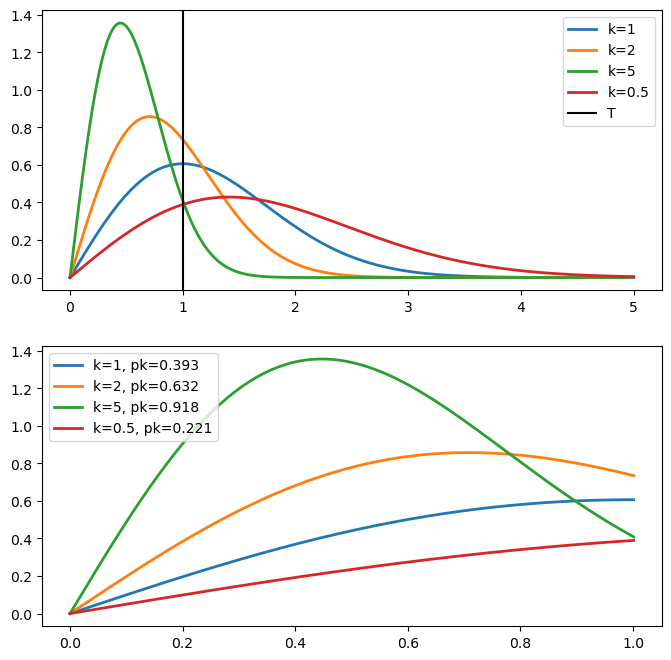

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(times, k1, lw=2, label="k=1")
ax[0].plot(times, k2, lw=2, label="k=2")
ax[0].plot(times, k5, lw=2, label="k=5")
ax[0].plot(times, k05, lw=2, label="k=0.5")
ax[0].axvline(x=1,  label = 'T', color ="black")
ax[0].legend(loc="upper right")
ax[1].plot(times[:201], k1[:201], lw=2, label=f"k=1, pk={pk1:.3f}")
ax[1].plot(times[:201], k2[:201], lw=2, label=f"k=2, pk={pk2:.3f}")
ax[1].plot(times[:201], k5[:201], lw=2, label=f"k=5, pk={pk5:.3f}")
ax[1].plot(times[:201], k05[:201], lw=2, label=f"k=0.5, pk={pk05:.3f}")
ax[1].legend(loc="upper left")


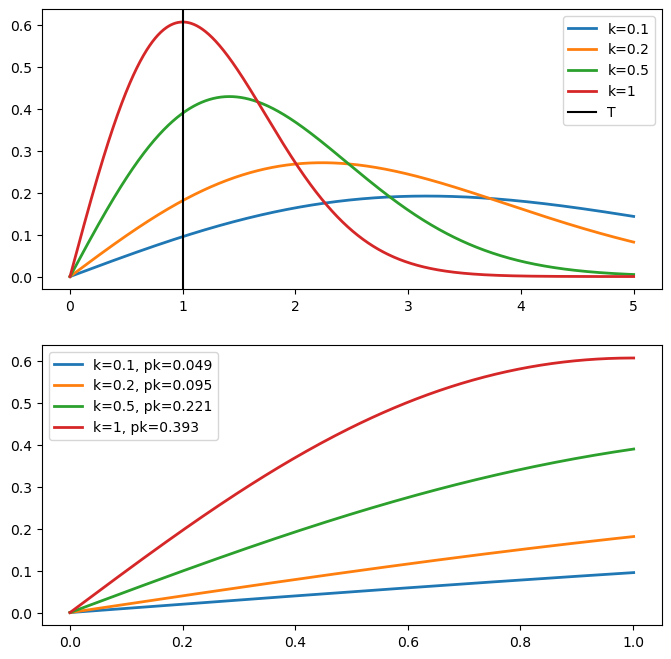

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(times, k01, lw=2, label="k=0.1")
ax[0].plot(times, k02, lw=2, label="k=0.2")
ax[0].plot(times, k05, lw=2, label="k=0.5")
ax[0].plot(times, k1, lw=2, label="k=1")
ax[0].axvline(x=1,  label = 'T', color ="black")
ax[0].legend(loc="upper right")
ax[1].plot(times[:201], k01[:201], lw=2, label=f"k=0.1, pk={pk01:.3f}")
ax[1].plot(times[:201], k02[:201], lw=2, label=f"k=0.2, pk={pk02:.3f}")
ax[1].plot(times[:201], k05[:201], lw=2, label=f"k=0.5, pk={pk05:.3f}")
ax[1].plot(times[:201], k1[:201], lw=2, label=f"k=1, pk={pk1:.3f}")
ax[1].legend(loc="upper left")

Recall that the compensated martingale $M_t$ follows $$M_t = 1_{\{\tau \leq t\}} - \int_0^t1_{\{\tau \geq s\}}dK_s = 1_{\{\tau \leq t\}} - \int_0^{\tau \wedge t}ksds = 1_{\{\tau \leq t\}} - \frac{k(\tau \wedge t)^2}{2}$$
We also have $$dM_t = d1_{\{\tau \leq t\}} - 1_{\{\tau \geq t\}}ktdt$$

We can find the largest $n$ such that $t_n \leq \tau$ (set $n = N+1$ if $\tau > T$). Call this $n_{\tau}$. Then 
$$\begin{align*}
\mathbb{P}(n_\tau \leq n)& = \mathbb{P}(\tau < t_{n+1}) = 1 - \exp(-\frac{k}{2}t_{n+1}^2)\\
\mathbb{P}(n_{\tau} = n) & = \mathbb{P}(\tau \in [t_n, t_{n+1})) \approx kt_n \exp(-\frac{k}{2}t_n^2)\Delta t  = \mathbb{P}(n_\tau > n - 1) kt_n\Delta t\\
\therefore \mathbb{P}(n_\tau = n+1 | n_\tau > n) & = kt_{n+1}\Delta t
\end{align*}
$$  We then define
$$
\begin{align*}
\Delta M_n & := \mathbb{1}_{\{n_\tau = n\}} - \mathbb{1}_{\{n_\tau \geq n\}}kt_n\Delta t\\
\mathbb{E}[\Delta M_{n+1}|\mathcal{G}_n] & = \mathbb{1}_{\{n_\tau > n\}}\mathbb{E}\left[\mathbb{1}_{\{n_\tau = n + 1\}} - \mathbb{1}_{\{n_\tau > n\}}kt_{n + 1}\Delta t| n_\tau > n \right]\\
& = \mathbb{1}_{\{n_\tau > n\}}\left(\frac{\mathbb{P}(n_\tau = n+1) - \mathbb{P}(n_\tau > n) kt_{n + 1}\Delta t}{\mathbb{P}(n_\tau > n)}\right) = 0
\end{align*}
$$

We will also need its second conditional moment.
$$\begin{align*}
(\Delta M_n)^2 & = \mathbb{1}_{\{n_\tau = n\}} + \mathbb{1}_{\{n_\tau \geq n\}}(kt_n\Delta t)^2 - 2\mathbb{1}_{\{n_\tau = n\}}kt_n\Delta t\\
& \approx \mathbb{1}_{\{n_\tau = n\}}\left[1 -2kt_n\Delta t\right]\\
\mathbb{E}[(\Delta M_{n+1})^2 | \mathcal{G}_n] & \approx \mathbb{1}_{\{n_\tau > n\}}\frac{\mathbb{P}(n_\tau = n +1)(1 - 2kt_{n+1}\Delta t)}{\mathbb{P}(n_\tau > n)}\approx \mathbb{1}_{\{n_\tau > n\}}kt_{n+1}\Delta t
\end{align*}
$$

This is the expected result since the quadratic variation of a compensated counting process is simply the compensator itself.

(array([ 29.,  68.,  93., 108., 125., 123., 123.,  88.,  85.,  55.,  31.,
         28.,  14.,  13.,   6.,   5.,   1.,   3.,   1.,   1.]),
 array([ 0.0802662 ,  0.71002494,  1.33978367,  1.9695424 ,  2.59930114,
         3.22905987,  3.8588186 ,  4.48857733,  5.11833607,  5.7480948 ,
         6.37785353,  7.00761226,  7.637371  ,  8.26712973,  8.89688846,
         9.52664719, 10.15640593, 10.78616466, 11.41592339, 12.04568212,
        12.67544086]),
 <BarContainer object of 20 artists>)

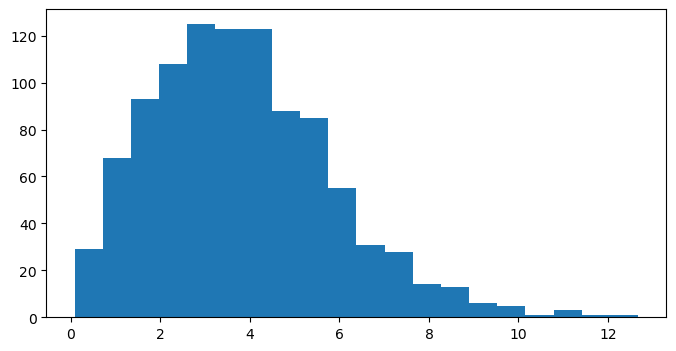

In [9]:
def find_k(T, p):
    return -2*np.log(1 - p)/(T**2)
def exoinvCDF(u, k):
    return (np.log((1-u)**(-1))*2/k)**(1/2)
taus = exoinvCDF(np.random.rand(1000), k=0.1)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(taus, bins=20)

## The model
We start with our driftless inventory $$X_t = \iota + \sigma W_t, \quad t \in [0, T].$$
The discretized version is $$X_{n+1} = \iota + \sigma \sum_{i = 1}^n\Delta W_i.$$


After Girsanov transformation, we have $$\tilde{X}_t = \iota + \int_0^t \alpha_sds + \sigma W^{\alpha}_t.$$
We choose $\iota \sim N(10, 2)$.

We set the bubble trend function to roughly match the LPPL model with critical time $t_0$, without oscillation. That is, $$\gamma_t = \int_0^t b(s)ds \approx \exp\left(A -B_0(t_0 - t)^\ell\right) - P_0$$ where $\ell \in (0, 1)$ controls price growth, and $B_0 > 0$ controls the scale of the power law. Matching initial value to be $0$, we have $$A = B_0(t_0)^\ell + \ln(P_0).$$
which gives us $$\gamma_t = P_0\exp\left(B_0(t_0)^\ell -B_0(t_0 - t)^\ell\right) - P_0.$$(Note that this should be interpreted as $\mathbb{E}(\ln(P_T))$.)

Matching derivative we have $$b(t) = P_0\exp\left(B_0(t_0)^\ell -B_0(t_0 - t)^\ell\right)(\ell B_0 (t_0 -t)^{\ell - 1})$$


Here we set our $t_0 = 1.1T$. We choose $P_0 = 10, \ell = 0.5, B_0 = \log(20)$ by default.

In [10]:
def getbt(t, B0 = np.log(20), beta= 0.5, P0 = 10, t0 = 1.1):
    #Bubble trend function, can take tgrid
    return P0*np.exp(B0*t0**beta - B0*(t0-t)**beta)*(beta*B0*(t0-t)**(beta - 1))

def getgammat(t, B0 = np.log(20), beta= 0.5, P0 =10, t0 = 1.1):
    #Bubble component
    return P0*np.exp(B0*t0**beta - B0*(t0-t)**beta) - P0

P0 = 10
beta=0.5
B0=np.log(20)
dt=1/N

PtsmallB0 = P0 + getgammat(tgrid, B0, beta, P0)
PtbigB0 = P0 + getgammat(tgrid, 1.3*B0, beta, P0)
PtbigB0bigBeta = P0 + getgammat(tgrid, 1.3*B0, 1.3*beta, P0)


We plot below the bubble function $b(t)$ for different values of $B_0$ and $\ell$.

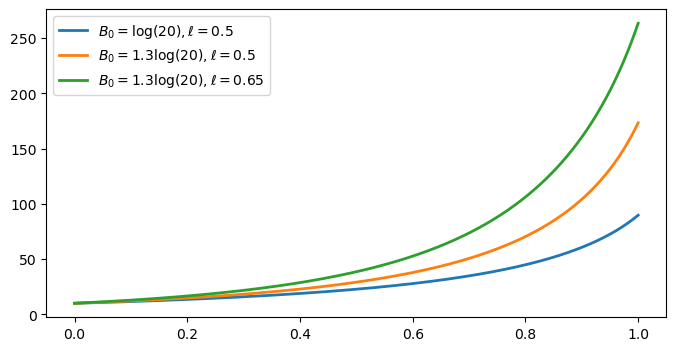

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(tgrid, PtsmallB0, lw=2, label=r"$B_0 = \log(20), \ell = 0.5$")
ax.plot(tgrid, PtbigB0, lw=2, label=r"$B_0 = 1.3\log(20), \ell = 0.5$")
ax.plot(tgrid, PtbigB0bigBeta, lw=2, label=r"$B_0 = 1.3\log(20), \ell = 0.65$")
ax.legend()

As time grows, the price drops more from the burst. $\beta_t$ is the fraction that controls the loss amplitude. For simplicity, we assume $\beta_t = 1$, that is, you won't lose more than you gain.

Then, with a quadratic terminal penalization, we have a terminal cost of $$g(X, \tau^*(\mu)) = X_{\tau^*(\mu)}\gamma_{\tau^*(\mu)} + cX_T^2$$
where $\tau^*(\mu):= \bar{\tau}(\mu) \wedge \tau$. We abbreviate $\tau^*(\mu)$ by $\tau^*$ now. Define $n_{\tau^*} := \max\{n: t_n \leq \tau^*\}$.

Recall the endogenous burst time is the first time that the running minimum of average inventory falls below a specified threshold $\zeta$ (capped at $T$). We choose $\zeta$ to be 20% of the average initial inventory, which is $2$. Define $n_{\bar{\tau}} := \max\{n: t_n \leq \bar{\tau}(\mu)\}$. It's easy to see that $n_{\tau^*} = n_\tau \wedge n_{\bar{\tau}}$.

The price impact function is assumed to be linear: $p(\bar{\theta}) = \delta*\bar{\theta}$ for some $\delta > 0$. Therefore, the running cost function is $$f(t, x, \theta, \tau^*, a) = \kappa a^2 + \phi x^2 - x\left(b(t)1_{\{t < \tau^*\}} + g\bar{\theta}\right)$$

The Hamiltonian is defined as $$H(t, x, \theta, \tau^*, a, z) = f(t, x, \theta, \tau^*, a) + a\sigma^{-1}z = \kappa a^2 + \phi x^2 - x\left(b(t)1_{\{t < \tau^*\}} + \delta\bar{\theta}\right) + a \sigma^{-1}z.$$
This is uniquely minimized by $$\hat{a}(z) = -\frac{z}{2\kappa \sigma}|_A = -\frac{1}{2\kappa\sigma}(z|_{2\kappa\sigma A}).$$

where we assume that $A$ is symmetric around $0$. The minimized Hamiltonian is therefore $$h(t,x,\theta, \tau^*, z) = H(t,x,\theta,\tau^*,\hat{a}(z), z) = \kappa \hat{a}(z)^2 + \sigma^{-1}\hat{a}(z)z + \phi x^2 - x\left(b(t)1_{\{t < \tau^*\}} + \delta\bar{\theta}\right) $$ which is almost quadratic in $z$ but still Lipschitz in $z$ due to boundedness of $A$ (the infimum of uniformly Lipschitz functions is Lipschitz). However, to simplify the numerical approximations, we assume that the bounds of $A$ are large enough so that $Z$ is almost always within range.

## The BSDE Algorithm

For given $(\theta, \mu)$ pair, we want to solve the following BSDE $$
\begin{align*}
\quad Y_t & = g(\tau^*, X) + \int_t^T h(s,X_s, \theta_s, \tau^*(\mu), Z_s)ds - \int_t^TZ_sdW_s - \int_t^TU_sdM_s.\\
& = X_{\tau^*(\mu)}\gamma_{\tau^*(\mu)} + cX_T^2 + \int_t^T \kappa \hat{a}(Z_s)^2 + \sigma^{-1}\hat{a}(Z_s)Z_s + \phi X_s^2 - X_s\left(b(s)\mathbb 1_{\{s < \tau^*\}} + \delta\bar{\theta_s}\right)ds\\
& - \int_t^T Z_sdW_s - \int_t^T U_sdM_s
\end{align*}$$

Now we look at the scheme 
$$\begin{align*}
Y_n & = Y_{n+1} + \left(\kappa \hat{a}(Z_n)^2 + \sigma^{-1}\hat{a}(Z_n)Z_n  + \phi X_n^2 - X_n(b(t_n)\mathbb{1}_{\{n < n_{\tau^*}\}}+\delta \bar{\theta}_{n})\right)\Delta t- Z_n\Delta W_{n+1} - U_n \Delta M_{n+1}\\
& =Y_{n+1} + \left(\kappa \hat{a}(Z_n)^2 + \sigma^{-1}\hat{a}(Z_n)Z_n + \phi X_n^2  - X_n(b(t_n)\mathbb{1}_{\{n < n_{\tau^*}\}}+\delta \bar{\theta}_{n})\right)\Delta t - Z_n\sqrt{\Delta t}\varepsilon_{n+1} - U_n( \mathbb{1}_{\{n_\tau = n+ 1\}} - \mathbb{1}_{\{n_\tau > n \}}kt_{n+1}\Delta t)
\end{align*}$$

This is no longer an implicit scheme since $h$ does not depend on $y$.

Multiply on both sides $\varepsilon_{n+1}$ and take conditional expectations. From the independence of $\varepsilon_{n+1}$ and $\Delta M_{n+1}$, we get $$Z_n = \frac{\mathbb{E}[Y_{n+1}\varepsilon_{n+1} | \mathcal{G}_n]}{\sqrt{\Delta t}} = \frac{Y_{n+1}^+ - Y^-_{n+1}}{2\sqrt{\Delta t}}$$

Here, $$
\begin{align*}
Y^{+}_{n+1} & = \mathbb{E}[Y_{n+1}|\mathcal{G}_n, \varepsilon_{n+1} = 1] = \mathbb{1}_{\{n_\tau \leq n\}}\mathbb{E}[Y_{n+1} |\mathcal{F}_n, n_\tau, \varepsilon_{n+1} = 1] + \mathbb{1}_{\{n_\tau > n\}}\mathbb{E}[Y_{n+1} |\mathcal{F}_n, n_\tau > n, \varepsilon_{n+1} = 1]\\
Y^{-}_{n+1} & = \mathbb{E}[Y_{n+1}|\mathcal{G}_n, \varepsilon_{n+1} = -1] = \mathbb{1}_{\{n_\tau \leq n\}}\mathbb{E}[Y_{n+1} |\mathcal{F}_n, n_\tau, \varepsilon_{n+1} = -1] + \mathbb{1}_{\{n_\tau > n\}}\mathbb{E}[Y_{n+1} |\mathcal{F}_n, n_\tau > n, \varepsilon_{n+1} = -1]
\end{align*}$$

Then we can plug these back into our explicit scheme by taking conditional expectation directly. This gives us $$Y_n = \mathbb{E}[Y_{n+1}|\mathcal{G}_n] + \left(\kappa \hat{a}(Z_n)^2 + \sigma^{-1}\hat{a}(Z_n)Z_n  + \phi X_n^2  - X_n(b(t_n)\mathbb{1}_{\{n < n_{\tau^*}\}}+\delta \bar{\theta}_{n}))\right)\Delta t$$

As suggested by the $\tau^*$-decomposition lemma, it is natural to break down the process into pre-$n_{\tau^*}$ and post $n_{\tau^*}$ sections (i.e., whether $n_{\tau^*}$ is $\mathcal{G}_n$-measurable). 


### Post burst algorithm
First, let's assume that $n_{\tau^*}$ "has happened". By Theorem 4.3 and 3.4, we will be adopt our scheme to be 
$$Y^1_{n} = Y^1_{n+1} + \left(\kappa \hat{a}(Z^1_n)^2 + \sigma^{-1}\hat{a}(Z^1_n)Z_n  + \phi X_n^2 - X_n\delta \bar{\theta}_{n}\right)\Delta t - Z^1_n\Delta W_{n+1}$$

To simplify notation, we shall drop the superscript $1$.

For each $n = 1, 2, \dots, N-2$, we take the ansatz first that $Y_{n+1}$ takes the form $$Y_{n+1} = c_{2, n+1}(X_{n+2})^2 + c_{1, n+1}X_{n+2} + c_{22, n+1}(X_{n+1})^2 + c_{0, n+1}X_{n+1} + c_{00, n+1} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}$$
where $c_{2, n+1}, c_{1, n+1}, c_{22, n+1}, c_{0, n+1}, c_{00, n+1}$ are constants. Note that $X_{n+1}$ is also $\mathcal{F}_n$-measurable, so it won't take an effect until the next iteration.

Then one uses the fact that $X_{n+2} = X_{n+1} + \sigma \sqrt{\Delta t} \varepsilon_{n+1}$ to find $$\begin{align*}
Y_{n+1}^+ & = c_{2, n+1}(X_{n+1} + \sigma \sqrt{\Delta t})^2 + c_{1, n+1}(X_{n+1} + \sigma \sqrt{\Delta t})+ c_{22, n+1}(X_{n+1})^2 + c_{0, n+1} X_{n+1} + c_{00, n+1} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}\\
Y_{n+1}^- & = c_{2, n+1}(X_{n+1} - \sigma \sqrt{\Delta t})^2 + c_{1,n+1}(X_{n+1} - \sigma \sqrt{\Delta t})+ c_{22, n+1}(X_{n+1})^2 + c_{0,n+1} X_{n+1} + c_{00, n+1} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}
\end{align*}$$
This gives us $$Z_{n} = 2c_{2,n+1}\sigma X_{n+1} + c_{1,n+1}\sigma$$
Notice that $Z_n$ is **linear** in $X_{n+1}$. This is expected since it is confirmed several times in the papers with explicit solutions.

Now suppose that $Z_{n}$ is *not truncated*. That is, $A_{min} \leq \hat{a}(Z_n) \leq A_{max}$. We then have $$\hat{a}(Z_n) = -\frac{Z_n}{2\kappa \sigma}$$

Plugging the ansatz and the form of $Z_n$ into the formula for $Y_n$, we get $$\begin{align*}
Y_n & = (c_{2, n+1} + c_{22, n+1})(X_{n+1})^2 + (c_{1, n+1} + c_{0, n+1} ) X_{n+1} +  c_{2, n+1}\sigma^2 \Delta t + c_{00, n+1} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}} + \left(-\frac{(Z_{n})^2}{4\kappa \sigma^2} + \phi (X_{n})^2- X_{n}\delta \bar{\theta}_n\right)\Delta t\\
& = \left(c_{2, n+1}+ c_{22, n+1} - \frac{c_{2, n+1}^2}{\kappa} \Delta t\right)(X_{n+1})^2 + \left(c_{1, n+1} + c_{0, n+1} - \frac{c_{1, n+1}c_{2, n+1}}{\kappa \sigma}\Delta t\right)X_{n+1} + (\phi\Delta t)(X_n)^2 + \left(-\delta \bar{\theta}_n\Delta t\right) X_n + \left[c_{00, n+1} + (c_{2, n+1}\sigma^2 - \frac{c_{1,n+1}^2}{4\kappa})\Delta t\right] + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}\\
& = c_{2, n}(X_{n+1})^2 + c_{1, n}X_{n+1} + c_{22, n}(X_n)^2+ c_{0, n}X_{n} + c_{00, n} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}
\end{align*}$$

where we update 
$$\begin{cases}
c_{2, n} \Longrightarrow & c_{2, n+1} + c_{22, n+1} - \frac{c_{2, n+1}^2}{\kappa} \Delta t\\
c_{1, n} \Longrightarrow & c_{1, n+1} + c_{0, n+1} - \frac{c_{1, n+1}c_{2, n+1}}{\kappa \sigma}\Delta t\\
c_{22, n} \Longrightarrow & \phi\Delta t\\
c_{0, n} \Longrightarrow & -\delta \bar{\theta}_n\Delta t\\
c_{00,n} \Longrightarrow & c_{00, n+1} + (c_{2, n+1}\sigma^2 - \frac{c_{1,n+1}^2}{4\kappa})\Delta t
\end{cases}$$

#### Initial + Final Step

Now set $$Y_N = cX_N^2 + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}, \quad Z_N = 0.$$
Note that this satisfies the ansatz with $$c_{22, N} = c, \quad c_{2,N}= c_{1,N}= c_{0,N}= c_{00,N} = 0$$


We show one step here. $Z_{N-1} = 0$ since everything is $\mathcal{F}_{N-1}$ measurable. We then have $$Y_{N-1} = cX_N^2 + \phi\Delta t(X_{N-1})^2 -  X_{N-1}\delta\bar{\theta}_{N-1}\Delta t + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}$$
which corresponds to the ansatz $$c_{2, N-1} = c, \quad c_{1, N-1} = 0, \quad c_{22, N-1} = \phi\Delta t, \quad c_{0, N-1} = -\delta\bar{\theta}_{N-1}\Delta t, \quad c_{00, N-1} = 0$$

From this algorithm, we are able to get $$Y_{n_{\tau^*}+1} = c_{2, n_{\tau^*}+1}(X_{n_{\tau^*} +2})^2 + c_{1,n_{\tau^*}+1}X_{n_{\tau^*} +2}+c_{22, n_{\tau^*}+1}(X_{n_{\tau^*} +1})^2 + c_{0, n_{\tau^*}+1}X_{n_{\tau^*} + 1} + c_{00, n_{\tau^*} + 1} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}$$ 
Then we go about calculating $$Y_{n_{\tau^*}} = \mathbb{E}[Y_{n_{\tau^*}+1}|\mathcal{G}_{n_{\tau^*}}] + \left(\kappa \hat{a}(Z_{n_{\tau^*}})^2 + \sigma^{-1}\hat{a}(Z_{n_{\tau^*}})Z_{n_{\tau^*}} +\phi(X_{n_\tau^*})^2 - X_{n_\tau^*}(b(t_{n_{\tau^*}})\mathbb{1}_{\{n < n_{\tau^*}\}}+\delta \bar{\theta}_{n_{\tau^*}}))\right)\Delta t$$
The bubble term is still not counted yet in this step. Therefore, we can still use the post-burst algorithm for all $n \geq n_{\tau^*}$ and arrive at $$Y_{n_{\tau^*}} = c_{2, n_{\tau^*}}(X_{n_{\tau^*} +1})^2 + c_{1,n_{\tau^*}}X_{n_{\tau^*} +1} +c_{22, n_{\tau^*}}(X_{n_{\tau^*}})^2+ c_{0, n_{\tau^*}}X_{n_{\tau^*}} + c_{00, n_{\tau^*}} + X_{n_{\tau^*}}\gamma_{n_{\tau^*}}$$ 

Specifically, we have an (somewhat) explicit formula for $Y^1_{n}(n)$ which is needed for the pre-burst section.

### Pre-burst Algorithm
Even though we call this Pre-burst algorithm, we still need to calculate the steps for all $n$ due to the backward nature. In particular, $n_{\bar\tau}$ is deterministic. While it is always greater than $n_{\tau^*}$, we still need to calculate the steps $n \geq n_{\bar\tau}$ in order to get the steps before $n_{\bar\tau}$. We start with $n \geq n_{\bar\tau}$ which will not be used directly.

Recall that our $\xi^0 = X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}} + cX_N^2$. Now we switch to the scheme

$$Y^0_{n} = Y^0_{n+1} + \left(\kappa \hat{a}(Z^0_n)^2 + \sigma^{-1}\hat{a}(Z^1_n)Z_n + \phi(X_n)^2- X_n(b(t_n) + \delta \bar{\theta}_{n}) + kt_n(Y^{1}_n(n) - Y^0_n) \right)\Delta t - Z^0_n\Delta W_{n+1}$$

Still, solving this gives us $$Z^0_n = \frac{Y^{0,+}_{n+1} - Y^{0,-}_{n+1}}{2\sqrt{\Delta t}}$$
From this, we can rearrange the terms and solve for $Y^0$ explicitly 

$$Y^0_n = \frac{1}{1 + kt_n\Delta t}\left(\mathbb{E}[Y^0_{n+1}| \mathcal{F}_n] +\left(\kappa \hat{a}(Z^0_n)^2 + \sigma^{-1}\hat{a}(Z^1_n)Z_n + \phi (X_n)^2- X_n(b(t_n) + \delta \bar{\theta}_{n}) + kt_nY^{1}_n(n) \right)\Delta t \right)$$

Now, we begin with the ansatz that for all $n_{\bar\tau} - 1\leq n \leq N - 2$,  $Y^0_{n+1}$ takes the form $$Y^0_{n+1} = d_{2, n+1}(X_{n+2})^2 + d_{1, n+1}X_{n+2} + d_{22, n+1}(X_{n+1})^2 + d_{0, n+1}X_{n+1} + d_{00, n+1} + d_{000, n + 1}X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}$$

Then one uses the fact that $X_{n+2} = X_{n+1} + \sigma \sqrt{\Delta t} \varepsilon_{n+1}$ to find $$\begin{align*}
Y_{n+1}^{0,+} & = d_{2, n+1}(X_{n+1} + \sigma \sqrt{\Delta t})^2 + d_{1, n+1}(X_{n+1} + \sigma \sqrt{\Delta t}) + d_{22, n+1}(X_{n+1})^2+ d_{0, n+1} X_{n+1} + d_{00, n+1} + d_{000, n}X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}\\
Y_{n+1}^{0,-} & = d_{2, n+1}(X_{n+1} - \sigma \sqrt{\Delta t})^2 + d_{1,n+1}(X_{n+1} - \sigma \sqrt{\Delta t}) + d_{22, n+1}(X_{n+1})^2+ d_{0,n+1} X_{n+1} + d_{00, n+1} + d_{000, n}X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}
\end{align*}$$
This gives us $$Z^0_n = 2d_{2, n+1}\sigma X_{n+1} + d_{1, n+1}\sigma$$
which is still **linear** in $X_{n+1}$. 

Suppose that $Z_{n}$ is *not truncated*. That is, $A_{min} \leq \hat{a}(Z_n) \leq A_{max}$. We then have $$\hat{a}(Z^0_n) = -\frac{Z^0_n}{2\kappa \sigma}$$

Plugging the ansatz and the form of $Z^0_n$ into the formula for $Y^0_n$, we get $$\begin{align*}
(1 + kt_n\Delta t)Y^0_n & = (d_{2, n+1}+d_{22, n+1})(X_{n+1})^2 + (d_{1, n+1} + d_{0, n+1} ) X_{n+1} +  d_{2, n+1}\sigma^2 \Delta t + d_{00, n+1} + d_{000, n + 1}X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}\\
&+\left[-\frac{(Z^0_{n})^2}{4\kappa \sigma^2} + \phi(X_n)^2 - X_{n}(b(t_n) + \delta \bar{\theta}_n)+ kt_n\left(c_{2, n}(X_{n+1})^2 + c_{1, n}X_{n+1} + c_{22, n}(X_{n})^2+ c_{0, n}X_{n} + c_{00, n}+ X_{n}\gamma_{n}\right)\right]\Delta t\\
& = \left(d_{2, n+1}+d_{22, n+1} - \frac{d_{2, n+1}^2}{\kappa} \Delta t + kt_nc_{2, n}\Delta t\right)(X_{n+1})^2 + \left(d_{1, n+1} + d_{0, n+1} - \frac{d_{1, n+1}d_{2, n+1}}{\kappa \sigma}\Delta t + kt_nc_{1,n}\Delta t\right)X_{n+1}\\
& + (\phi\Delta t + kt_nc_{22,n}\Delta t)(X_n)^2+ \left((-b(t_n)-\delta \bar{\theta}_n + kt_n(c_{0,n} + \gamma_n))\Delta t\right) X_n + \left[d_{00, n+1} + (d_{2, n+1}\sigma^2 - \frac{d_{1,n+1}^2}{4\kappa} + kt_nc_{00, n})\Delta t\right] + d_{000, n+1}X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}\\
Y^0_n & = d_{2, n}(X_{n+1})^2 + d_{1, n}X_{n+1} + d_{22, n}(X_{n})^2 + d_{0, n}X_{n} + d_{00, n} + d_{000, n}X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}
\end{align*}$$

where we update 
$$\begin{cases}
d_{2, n} \Longrightarrow & \frac{1}{1 + kt_n\Delta t}\left(d_{2, n+1} - \frac{d_{2, n+1}^2}{\kappa} \Delta t +d_{22, n+1}+ kt_nc_{2,n}\Delta t\right)\\
d_{1, n} \Longrightarrow & \frac{1}{1 + kt_n\Delta t}\left(d_{1, n+1} + d_{0, n+1} - \frac{d_{1, n+1}d_{2, n+1}}{\kappa \sigma}\Delta t + kt_nc_{1,n}\Delta t \right)\\
d_{22, n} \Longrightarrow & \frac{1}{1 + kt_n\Delta t}(\phi\Delta t + kt_{n}c_{22, n}\Delta t)\\
d_{0, n} \Longrightarrow & \frac{1}{1 + kt_n\Delta t}\left((-b(t_n)-\delta \bar{\theta}_n + kt_n(c_{0, n}+\gamma_n))\Delta t \right)\\
d_{00,n} \Longrightarrow & \frac{1}{1 + kt_n\Delta t}\left(d_{00, n+1} + (d_{2, n+1}\sigma^2 - \frac{d_{1,n+1}^2}{4\kappa}+ kt_nc_{00,n})\Delta t \right)\\
d_{000, n}\Longrightarrow & \frac{1}{1 + kt_n\Delta t}d_{000, n+1}
\end{cases}$$

#### Initial + Middle + Final Step

We can then get $$\begin{align*}
Y_{n_{\bar\tau}} &= d_{2, n_{\bar\tau}}(X_{n_{\bar\tau}+1})^2 + d_{1, n_{\bar\tau}}X_{n_{\bar\tau}+1} + d_{22, n_{\bar\tau}}(X_{n_{\bar\tau}})^2+ d_{0, n_{\bar\tau}}X_{n_{\bar\tau}} + d_{00, n_{\bar\tau}} + d_{000, n_{\bar\tau}}X_{n_{\bar\tau}}\gamma_{n_{\bar\tau}}\\
& =d_{2, n_{\bar\tau}}(X_{n_{\bar\tau}+1})^2 + d_{1, n_{\bar\tau}}X_{n_{\bar\tau}+1} + d_{22, n_{\bar\tau}}(X_{n_{\bar\tau}})^2+(d_{0, n_{\bar\tau}} + d_{000, n_{\bar\tau}}\gamma_{n_{\bar\tau}})X_{n_{\bar\tau}} + d_{00, n_{\bar\tau}} 
\end{align*}$$


Here, we abuse notation and update $d_{0, n_{\bar\tau}} \longleftarrow d_{0, n_{\bar\tau}} + d_{000, n_{\bar\tau}}\gamma_{n_{\bar\tau}}$. After this step, the ansatz becomes $$Y_n = d_{2, n}(X_{n+1})^2 + d_{1, n}X_{n+1} + d_{22, n}(X_{n})^2+ d_{0, n}X_{n} + d_{00, n}$$
But since this is still quadratic in $X$, the updating rule remains the same (except no more $d_{000, n_{\bar\tau}}$). However, we will never use these $d_n$ coefficients for $n > n_{\bar\tau}$ since we will be switching to the post-burst algorithm. Therefore, there is no need to store $d_{000, n}$ as long as we keep track of it for this one step.

We set $Z_{N} = 0, Y_{N} = X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}} + cX_N^2$. Notice that this corresponds to $$d_{22, N} = c, \quad d_{2, N} = d_{1, N} = d_{0, N} = d_{00, N} = 0, \quad d_{000, N} = 1$$

Now we show one step. $Z_{N-1} = 0$ since everything is $\mathcal{F}_{N-1}$-measurable.  Plugging in $c_{2, N-1} = c, \quad c_{1, N-1} = 0, \quad c_{22, N-1} = \phi\Delta t, \quad c_{0, N-1} = -\delta\bar{\theta}_{N-1}\Delta t, \quad c_{00, N-1} = 0$ yields$$\begin{align*}
(1 + kt_{N-1}\Delta t)Y_{N-1} &= X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}} + cX_N^2  + X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}\\
& + \left(\phi (X_{N-1})^2- X_{N-1}(b(t_{N-1}) + \delta \bar{\theta}_{N-1}) + kt_{N-1}\left(c_{2, N-1}(X_{N})^2 + c_{1, N-1}X_{N} + c_{22, N-1}(X_{N-1})^2+ c_{0, N-1}X_{N-1} + c_{00, N-1}+ X_{N-1}\gamma_{N-1}\right) \right)\Delta t\\
& =\left(c +kt_{N-1}c_{2,N-1}\Delta t\right)X_N^2  + kt_{N-1}c_{1, N-1}\Delta t X_N + \left(\phi \Delta t + kt_{N-1}c_{22, N-1}\Delta t\right)(X_{N-1})^2\\
& + \left((kt_{N-1}(c_{0, N-1}+\gamma_{N-1})-b(t_{N-1})-\delta\bar{\theta}_{N-1})\Delta t\right)X_{N-1} + kt_{N-1}c_{00, N-1}\Delta t+ X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}\\
& = \left(c +ckt_{N-1}\Delta t\right)X_N^2 + \left(\phi \Delta t + kt_{N-1}\phi(\Delta t)^2\right)(X_{N-1})^2 + \left((kt_{N-1}(-\delta\bar{\theta}_{N-1}\Delta t+\gamma_{N-1})-b(t_{N-1})-\delta\bar{\theta}_{N-1})\Delta t\right)X_{N-1}+ X_{n_{\bar{\tau}}}\gamma_{n_{\bar{\tau}}}
\end{align*}$$ 

We then have $$\begin{align}
d_{2, N-1} & = \frac{1}{1 + kt_{N-1}\Delta t}\left(c +ckt_{N-1}\Delta t\right), \quad d_{1, N-1}  = 0, \quad d_{22, N-1} = \frac{1}{1 + kt_{N-1}\Delta t}\left(\phi \Delta t + kt_{N-1}\phi(\Delta t)^2\right)\\
d_{0, N-1} & = \frac{1}{1 + kt_{N-1}\Delta t}\left((kt_{N-1}(-\delta\bar{\theta}_{N-1}\Delta t+\gamma_{N-1})-b(t_{N-1})-\delta\bar{\theta}_{N-1})\Delta t\right) \\
d_{00, N-1} & = 0, \quad d_{000, N-1} = \frac{1}{1 + kt_{N-1}\Delta t}
\end{align}$$

We describe the algorithm for solving the BSDE given a pair $(\bar \mu, \bar \theta)$. **We choose temporary impact $\kappa = 0.5$, permanent impact $\delta = 0.5$, running cost $\phi = 0.1$, and terminal cost $c = 10$. Recall we also choose $\sigma = 1$.**

- Calculate $\bar{\tau}(\mu)$ and $n_{\bar\tau}$.

- Set $$c_{22, N} = c, \quad c_{2,N}= c_{1,N}= c_{0,N}= c_{00,N} = 0$$

- Start the NO TRUNCATION, post-burst algorithm to calculate $c_{2, n}, c_{1, n}, c_{22,n}, c_{0, n}$, and $c_{00, n}$ for $0 \leq n \leq N -1$. We get a $(N+1)\times 5$ matrix of coefficients $C$.

- Set $$d_{22, N} = c, \quad d_{2, N} = d_{1, N} = d_{0, N} = d_{00, N} = 0, \quad d_{000, N} = 1$$

- Use these and apply the NO TRUNCATION, pre-burst algorithm to calculate $d_{2,n}, d_{1, n}, d_{0, n}$, $d_{00, n}$, and $d_{000,n}$ for $n_{\bar\tau} \leq n \leq N -1$.

- Update $d_{0, n_{\bar\tau}} \longleftarrow d_{0, n_{\bar\tau}} + d_{000, n_{\bar\tau}}\gamma_{n_{\bar\tau}}$.

- Proceed to calculate $d_{2,n}, d_{1, n}, d_{22,n}, d_{0, n}$ and $d_{00, n}$ for $0 \leq n \leq n_{\bar\tau} -1$. We get a $(N+1)\times 5$ matrix of coefficients $D$.

- Then we have explicit solution $$\begin{align}
Z_n & = Z^0_n\mathbb{1}_{\{n \leq n_{\tau^*}\}} + Z^1_n\mathbb{1}_{\{n > n_{\tau^*}\}}\\
& = \left(2d_{2, n+1}\sigma X_{n+1} + d_{1, n+1}\sigma\right)\mathbb{1}_{\{n \leq n_{\tau^*}\}} + \left(2c_{2,n+1}\sigma X_{n+1} + c_{1,n+1}\sigma\right)\mathbb{1}_{\{n_{\tau^*} < n \leq N - 1\}}\\
Y_n & = Y^0_n\mathbb{1}_{\{n < n_{\tau^*}\}} + Y^1_n\mathbb{1}_{\{n_{\tau^*} \leq n \leq N\}}\\
& = \left(d_{2, n}(X_{n+1})^2 + d_{1, n}X_{n+1} + d_{22, n}(X_{n})^2  + d_{0, n}X_{n} + d_{00, n}\right)\mathbb{1}_{\{n < n_{\tau^*}\}} + \left(c_{2, n}(X_{n+1})^2 + c_{1, n}X_{n+1} +c_{22, n}(X_{n})^2 + c_{0, n}X_{n} + c_{00, n}+ X_{n_{\tau^*}}\gamma_{n_{\tau^*}}\right)\mathbb{1}_{\{n_{\tau^*} \leq n \leq N -1\}} + \left(cX_N^2 +X_{n_{\tau^*}}\gamma_{n_{\tau^*}}\right)\mathbb{1}_{\{n = N\}}
\end{align}
$$

The objective value is equal to $$\begin{align*}
\mathbb{E}[Y_0] & = d_{2, 0}\mathbb{E}[(X_{1})^2] + d_{1, 0}\mathbb{E}[X_{1}] + d_{22, 0}\mathbb{E}[(X_{0})^2]  + d_{0, 0}\mathbb{E}[X_{0}] + d_{00, 0}\\
& = d_{2, 0}\left(\mathbb{E}[(\iota)^2] + \sigma^2 \Delta t\right) + d_{1, 0}\mathbb{E}[\iota] + d_{22, 0}\mathbb{E}[\iota^2]  + d_{0, 0}\mathbb{E}[\iota] + d_{00, 0}
\end{align*}
$$

### Implementation

In [12]:
class BSDEobject:
    N = 1000
    theta = np.append(-20*np.ones(int(N/2)), np.zeros(int(N/2+1))) #Initial values
    mu = np.append(10-20*tgrid[:int(N/2)], np.zeros(int(N/2)+1)) #Initial values

    
    def __init__(self, c, kappa, delta, phi, sigma, zeta, k, T ,
                B0 , beta, P0 , t0scale): #Parameters in the second line are for price
        
        self.c = c
        self.kappa = kappa
        self.delta = delta
        self.phi = phi
        self.sigma = sigma
        self.zeta = zeta
        self.k = k
        self.T = T
        self.B0 = B0
        self.beta = beta
        self.P0 = P0
        
        self.tgrid = np.linspace(0., T, N+1)
        self.dt = T/N #we have a grid of N+1 points, so each dt is T/N
    
        self.t0 = t0scale*T
        #Bubble trend function
        self.bt = P0*np.exp(B0*self.t0**beta - B0*(self.t0-self.tgrid)**beta)*(beta*B0*(self.t0-self.tgrid)**(beta - 1))
        #Bubble component
        self.gammat = P0*np.exp(B0*self.t0**beta - B0*(self.t0-self.tgrid)**beta) - P0
        
        m = np.minimum.accumulate(self.mu) #running minimum
        if m[-1] > self.zeta: #If the average inventory never falls below the threshold, burst at time T.
            self.ntaubar, self.taubar = int(self.N), self.T 
        else:
            self.ntaubar = int(np.min(np.where(m <= self.zeta)))
            self.taubar = self.tgrid[self.ntaubar]
        self.C = self.getC()
        self.D = self.getD(self.C)
    def getC(self):
        #The post-burst, No Truncation matrix C
        cinit = np.array([0, 0, self.c, 0, 0]) #each row is (c2n, c1n, c22n, c0n, c00n)
        C = np.zeros((self.N+1, 5))
        C[self.N] = cinit
        for n in range(self.N-1, -1, -1):
            c2, c1, c22, c0, c00 = C[n+1]
            C[n] = [c2 + c22 - (c2**2*self.dt)/self.kappa,
                    c1 + c0 - (c1*c2*self.dt)/(self.kappa * self.sigma),
                    self.phi*self.dt, -self.delta*self.theta[n]*self.dt,
                    c00 + (c2*self.sigma**2 - (c1**2)/(4*self.kappa))*self.dt]
        return C
        
    def getD(self, C):
        #The pre-burst, No Truncation matrix D
        #Need the 4x(N+1) matrix C from post-burst. Also, need k, the exogenous burst intensity parameter, bt and gammat the bubble components
        dinit = np.array([0, 0, self.c, 0, 0]) #each row is (d2n, d1n, d22n, d0n, d00n)
        d000 = 1
        D = np.zeros((self.N+1, 5))
        D[self.N] = dinit
        for n in range(self.N-1, self.ntaubar-1, -1): #Calculate D down to the n_taubar'th iteration
            c2, c1, c22, c0, c00 = C[n]
            d2, d1, d22, d0, d00 = D[n+1]
            tn = self.tgrid[n]
            ratio = 1/(1+ self.k*tn*self.dt)
            D[n] = ratio*np.array(
                    [d2 + d22 - (d2**2*self.dt)/self.kappa + self.k*tn*c2*self.dt,
                    d1 + d0 - (d1*d2*self.dt)/(self.kappa * self.sigma) + self.k*tn*c1*self.dt,
                    self.phi*self.dt + self.k*tn*c22*self.dt, (-self.bt[n] - self.delta*self.theta[n] + self.k*tn*(c0 + self.gammat[n]))*self.dt,
                    d00 + (d2*self.sigma**2 - (d1**2)/(4*self.kappa) + self.k*tn*c00)*self.dt])
            d000 = ratio*d000

        D[self.ntaubar, 3] = D[self.ntaubar, 3] + d000*self.gammat[self.ntaubar]
        for n in range(self.ntaubar-1, -1, -1): #Resume calculation
            c2, c1, c22, c0, c00 = C[n]
            d2, d1, d22, d0, d00 = D[n+1]
            tn = self.tgrid[n]
            ratio = 1/(1+ self.k*tn*self.dt)
            D[n] = ratio*np.array(
                    [d2 + d22 - (d2**2*self.dt)/self.kappa + self.k*tn*c2*self.dt,
                    d1 + d0 - (d1*d2*self.dt)/(self.kappa * self.sigma) + self.k*tn*c1*self.dt,
                    self.phi*self.dt + self.k*tn*c22*self.dt, (-self.bt[n] - self.delta*self.theta[n] + self.k*tn*(c0 + self.gammat[n]))*self.dt,
                    d00 + (d2*self.sigma**2 - (d1**2)/(4*self.kappa) + self.k*tn*c00)*self.dt])
        return D

    def update(self, newmu, newtheta):
        #A method that updates mu, theta, ntaubar, C and D
        self.mu = newmu
        self.theta = newtheta
        
        #Update ntaubar
        m = np.minimum.accumulate(self.mu) #running minimum
        if m[-1] > self.zeta: #If the average inventory never falls below the threshold, burst at time T.
            self.ntaubar, self.taubar = int(self.N), self.T 
        else:
            self.ntaubar = int(np.min(np.where(m <= self.zeta)))
            self.taubar = self.tgrid[self.ntaubar]
            
        #Update C and D
        self.C = self.getC()
        self.D = self.getD(self.C)
    @classmethod
    def update_N(cls, newN):
        #Changes N permanently
        cls.N = newN


## The MFG-BSDE Algorithm

We first recall that $n_{\tau^*}$ can take values in $\{0, 1, \dots, n_{\bar{\tau}}\}$ with probability $$\mathbb{P}(n_{\tau^*} = n) = \mathbb{P}(n_{\tau} = n)\mathbb{1}_{\{n < n_{\bar{\tau}}\}} + \mathbb{P}(n_{\tau} \geq n_{\bar{\tau}})\mathbb{1}_{\{n = n_{\bar{\tau}}\}} = \begin{cases}
kt_n\exp(-\frac{k}{2}t_{n}^2)\Delta t & \text{ if } n < n_{\bar{\tau}}\\
\exp(-\frac{k}{2}t_{n_{\bar{\tau}}}) & \text{ if } n = n_{\bar{\tau}}\\
0 & \text{ if } n > n_{\bar{\tau}}
\end{cases}$$


$$\mathbb{P}(n_{\tau^*} \geq n) = \mathbb{P}(n_{\tau^*} > n -1) = \mathbb{P}(n_{\tau} \geq n)\mathbb{1}_{\{n_{\bar{\tau}} \geq n \}} = \begin{cases}
\exp(-\frac{k}{2}t_{n}) & \text{ if } n_{\bar{\tau}} \geq n\\
0 & \text{ if }  n_{\bar{\tau}}<n
\end{cases}$$

$$\mathbb{P}(n_{\tau^*} < n) =  \begin{cases}
1-\exp(-\frac{k}{2}t_{n}) & \text{ if } n_{\bar{\tau}} \geq n\\
1 & \text{ if }  n_{\bar{\tau}}<n
\end{cases}$$

At iteration $l$, with some given $\bar\mu^l$ and $\bar\theta^l$, we get $Z^l(X, \tau)$ from the BSDE, which then gives us $\hat\alpha^l(X, \tau) = -\frac{Z^l(X, \tau)}{2\kappa\sigma}$. The optimal inventory (has the same law as) $$\widetilde{X}^l_t = X_t + \int_0^t\hat{\alpha}^l_s(X,\tau)ds$$

By independence of $\tau$ and $W$, the output $\bar\mu^{l+1}$ is $$\begin{align}
\bar\mu^{l+1}_n & := \mathbb{E}[\widetilde{X}^l_n] = \mathbb{E}[X_n]+ \sum_{j = 1}^n \mathbb{E}[\hat{\alpha}_j^l(X, \tau)]\Delta t\\
& = \mathbb{E}[\iota + \sigma W_n] + \Delta t\sum_{j = 1}^n \left [\mathbb{P}( n_{\tau^*} \geq n)\frac{-2d_{2, n+1}\mathbb{E}[X_{n+1}] - d_{1, n+1}}{2\kappa} + \mathbb{P}(n_{\tau^*} < n )\frac{-2c_{2, n+1}\mathbb{E}[X_{n+1}] - c_{1, n+1}}{2\kappa} \right]\\
& = \mathbb{E}[\iota] -\frac{\Delta t}{2\kappa}\sum_{j = 1}^n \left[\mathbb{1}_{\{n_{\bar\tau} \geq n\}}\exp(-\frac{k}{2}t_{n})(2d_{2, n+1}\mathbb{E}[\iota]+d_{1, n+1}) + 2c_{2, n+1}\mathbb{E}[\iota] + c_{1, n+1} - \mathbb{1}_{\{n_{\bar\tau} \geq n\}}\exp(-\frac{k}{2}t_{n})(2c_{2, n+1}\mathbb{E}[\iota] + c_{1, n+1})\right]\\
& = \mathbb{E}[\iota]-\frac{\Delta t}{2\kappa}\sum_{j = 1}^n \left[\mathbb{1}_{\{n_{\bar\tau} \geq n\}}\exp(-\frac{k}{2}t_{n})\left(2d_{2, n+1}\mathbb{E}[\iota]+d_{1, n+1} - 2c_{2, n+1}\mathbb{E}[\iota] - c_{1, n+1} \right) + 2c_{2, n+1}\mathbb{E}[\iota] + c_{1, n+1}\right]
\end{align}$$

Alternatively, since we will have to do Monte-Carlo for $\bar\theta^l$ anyways, we can also use those simulations to get $$\bar\mu^{l+1}_n = \mathbb{E}[\iota] + \Delta t \sum_{j = 1}^n\frac 1 M \sum_{m= 1}\hat{\alpha}_j^{l, m}$$

The output $\bar{\theta}^{l+1}$ is a bit more complicated. Recall that the fixed point condition is imposed on the law of $\hat{\alpha}$ under $\mathbb{P}^{\hat\alpha}$ instead of $\mathbb{P}$. Therefore, we first define $$E^l = \exp\left(\sum_{n=1}^N\sigma^{-1}\hat{\alpha}^l_n\Delta W_n - \frac{1}{2}\sum_{n = 1}^N(\sigma^{-1}\hat{\alpha}^l_n)^2\Delta t\right)$$

Then our output is $$\bar\theta^{l+1}_n := \mathbb{E}[E^l\hat{\alpha}^l_n]$$

To approximate this, for each iteration $l$, we generate $M$ independent triplets $\{(W, \tau, \iota)^m = (W^m, \tau^m, \iota^m)\}_{m =1 ,\dots, M}$. We then get $X^{l, m}, n_{\tau^*}^{l, m}, Z^{l, m}, \hat\alpha^{l, m}$ and then $E^{l, m}$. We shall compute the Monte-Carlo expectation by simply averaging over these simulations: $$\bar\theta^{l+1}_n = \frac 1 M \sum_{m = 1}^M E^{l, m}\hat\alpha^{l,m}_n$$

We then use $(\bar\mu^{l+1}, \bar\theta^{l+1})$ as input. We keep iterating until we reach a pre-determined stopping criterion $$\begin{align}
||\bar\mu^{l+1} - \bar\mu^{l}|| & \leq \varepsilon_\mu\\
\text{and }||\bar\theta^{l+1} - \bar\theta^{l}|| & \leq \varepsilon_\theta
\end{align}$$

In practice, thanks to the linear-quadratic structure, the convergence is really fast. Consistently, it only takes about 10 iterations to converge, so we simply run 15 iterations.

We will initiate with a constant selling strategy until sold out. Say $$\bar{\theta}^0_n = -20\mathbb{1}_{\{n \leq N/2\}}$$ with corresponding $$\bar{\mu}^0_n = (10 - 20t_n)\mathbb{1}_{\{n \leq N/2\}}$$

### Coding for BSDE

We first define the following functions for drawing the random parts here ($W_t$ and $M_t$).

In [13]:
class MFGobject(BSDEobject):
    M = 1000 #Number of random draws for MonteCarlo within each iteration
    L = 15 #Numeber of Iterations on mu and theta. More than 10 is sufficient
    def __init__(self, c = 10, kappa = 0.5, delta = 0.5, phi = 0.1, sigma = 1, zeta = 2, k = 2, T = 1,
                B0 = np.log(20), beta= 0.5, P0 = 10, t0scale = 1.1, #Parameters in the second line are for price
                iotamean = 10, iotavar = 2):  #Info on Iota
        super().__init__(c, kappa, delta, phi, sigma, zeta, k, T,  B0, beta, P0, t0scale)
        self.iotamean = iotamean
        self.iotavar = iotavar
        self.iotasd = np.sqrt(self.iotavar)
        self.secondmoment = self.iotavar + (self.iotamean)**2
    def exoinvCDF(self, u):
        #helper function for drawing taus.
        return (np.log((1-u)**(-1))*2/self.k)**(1/2)
    
    def gettau(self):
        #Draw M exogenous burst times
        taus = self.exoinvCDF(np.random.rand(self.M))
        ntaus = self.N*np.ones(self.M) #Cap ntau at N
        for m in range(self.M):
            if taus[m] < self.T:
                tau = taus[m]
                ntaus[m] = int(np.max(np.where(self.tgrid <= tau)))
        return ntaus, taus

    def getdWt(self):
        #This is not Wt, but rather dWt. The only randomness in W and X.
        #dWn = Wn - Wn-1
        #Returns a vector of length N (with starting index 1).
        bernoulli = np.random.randint(2, size=self.N)
        rade = ((bernoulli<.5)*2 - 1) #We use Rademacher since it's easier in the discretization step. 
        return np.sqrt(self.dt)*rade
    
    def getiota(self):
        #Draw M iotas
        return self.iotamean + self.iotasd*np.random.randn(self.M)

    @staticmethod
    def getWt(dWt):
        #Returns an array of length N+1 since we have W_0 = 0 
        return np.append([0], np.cumsum(dWt))

    def getX(self, Wt, iota):
        #Returns an array of length N+1 since we have X_0 = iota
        return iota + self.sigma*Wt

    def gettildes(self, iota, dWt, ntau):
        #Both alpha and X tilde here are the strong solution in P, not P^alpha
        #alpha is length N+1 (with last step = the previous step for convenience), Xtilde is length N+1
        #dWt is length N
        ntaustar = int(np.min([self.ntaubar, ntau]))
        ratio = 1/(2*self.kappa)
        alpha = np.zeros(self.N+1) #Only N of these make sense since there is no control needed at the last step.
        Xtilde = np.zeros(self.N+1)
        Xtilde[0] = iota
        for n in range(ntaustar): #Pre-burst
            alpha[n] = ratio*(-2*self.D[n, 0]*Xtilde[n] - self.D[n, 1])
            Xtilde[n+1] = Xtilde[n] + self.dt*alpha[n] + dWt[n]*self.sigma 
        if ntaustar != self.N: #post-burst
            for n in range(ntaustar, self.N):
                alpha[n] = ratio*(-2*self.C[n, 0]*Xtilde[n] - self.C[n, 1])
                Xtilde[n+1] = Xtilde[n] + self.dt*alpha[n] + dWt[n]*self.sigma 
        alpha[self.N] = alpha[self.N-1] 
        return alpha, Xtilde

    def getY0(self):
        #Returns the objective value for the optimal control
        return self.D[0][0]*(self.secondmoment + self.sigma**2*self.dt) + self.D[0][1]*self.iotamean + self.D[0][2]*self.secondmoment + self.D[0][3]*self.iotamean + self.D[0][4]
    
    def solve(self):
        #The main solving method to be called.
        #Algorithm runs L iterations. 
        #Within each there are M random samples drawn on a time grid of N points.
        self.maxalpha = 0
        for l in trange(self.L):
            self.iotas = self.getiota()
            self.ntaus, self.taus = self.gettau()
            self.alphas = np.zeros((self.M, self.N+1))
            self.Xtildes = np.zeros((self.M, self.N+1))
            for m in range(self.M):
                #First collect the random parts
                dWt = self.getdWt()
                iota = self.iotas[m]
                ntau = self.ntaus[m]
                #Solve for optimal alpha and corresponding Xtilde 
                self.alphas[m], self.Xtildes[m] = self.gettildes(iota = iota, dWt=dWt, ntau = ntau)
            mu = np.mean(self.Xtildes, axis = 0)
            theta = np.mean(self.alphas, axis = 0)
            self.update(newmu = mu, newtheta = theta) #Recall that this updates ntaubar as well.
            self.maxalpha = np.max([self.maxalpha, np.max(np.abs(self.alphas))])
        self.obj = self.getY0()
        self.n_exo = np.min(np.where(self.ntaus < min(self.ntaubar, 0.6*self.N)))
        self.n_endo = np.min(np.append(np.where(self.ntaus > self.ntaubar), self.N-1))
        self.exoPercent = np.sum(self.ntaus < self.ntaubar)/self.M
        self.endoPercent = 1 - self.exoPercent
        
    def burst_analysis(self):
        #Only use once the solve method has been called (so that mu, theta, ntaubar are stablized).
        #Returns the inventory levels at burst time and also at endogenous burst time if there wasn't an exogenous burst
        iotas = self.getiota()
        ntaus, taus = self.gettau()
        alphas = np.zeros((self.M, self.N+1))
        Xtildes = np.zeros((self.M, self.N+1))
        Xtilde_taubar = np.zeros(self.M) #Inventory levels at an endogenous burst (expected)
        Xtilde_taustar = np.zeros(self.M) #Inventory levels at burst
        ntaustars = np.zeros(self.M)
        loss_taubar=np.zeros(self.M)
        loss_taustar=np.zeros(self.M) #True loss
        for m in range(self.M):
            #First collect the random parts
            dWt = self.getdWt()
            iota = iotas[m]
            ntau = ntaus[m]
            ntaustars[m] = np.min([self.ntaubar, ntau])
            #Solve for optimal alpha and corresponding Xtilde 
            alphas[m], Xtildes[m] = self.gettildes(iota = iota, dWt=dWt, ntau = ntau)
            Xtilde_taubar[m] = Xtildes[m][self.ntaubar]
            Xtilde_taustar[m] = Xtildes[m][int(ntaustars[m])]
            loss_taubar[m] = Xtilde_taubar[m]*self.gammat[self.ntaubar]
            loss_taustar[m] = Xtilde_taubar[m]*self.gammat[int(ntaustars[m])]
        self.Xtilde_taubar, self.Xtilde_taustar, self.loss_taubar, self.loss_taustar = Xtilde_taubar, Xtilde_taustar, loss_taubar, loss_taustar
    
    def tau_analysis(self, N_ntaus = 50):
        #Only use once the solve method has been called (so that mu, theta, ntaubar are stablized).
        #Returns how people react to exogenous shocks at different times.
        
        taus = np.delete(np.linspace(0., self.taubar, N_ntaus + 1), 0) #No need for taus after taubar. Remove 0.
        ntaus = np.zeros(N_ntaus)
        for i in range(N_ntaus):
            ntaus[i]= int(np.max(np.where(self.tgrid <= taus[i])))
        mus_ntau = np.zeros((N_ntaus, self.N + 1))
        thetas_ntau = np.zeros((N_ntaus, self.N + 1))
        iotas = self.getiota() #same iotas
        
        alphas = np.zeros((self.M, self.N+1))
        Xtildes = np.zeros((self.M, self.N+1))
        
        dWts = np.zeros((self.M, self.N))
        for m in range(self.M):
            dWts[m] = self.getdWt() #same noise
        for i in range(N_ntaus):
            ntau = ntaus[i] #same ntau
            for m in range(self.M):
                alphas[m], Xtildes[m] = self.gettildes(iota = iotas[m], dWt=dWts[m], ntau = ntau) #Solve for optimal alpha and corresponding Xtilde         
            mus_ntau[i] = np.mean(Xtildes, axis = 0)
            thetas_ntau[i] = np.mean(alphas, axis = 0)
        self.testtaus, self.mus_ntau, self.thetas_ntau = taus, mus_ntau, thetas_ntau
    
    def get_k_analysis(self, ks):
        #Only use once the solve method has been called (so that mu, theta, ntaubar are stablized).
        copyself = copy.deepcopy(self) #So that the original instance is not contaminated
        K = len(ks) #Don't give too many of these
        theta_ks = np.zeros((K, N+1))
        mu_ks = np.zeros((K, N+1))
        obj_ks = np.zeros(K)
        endoPercent_ks = np.zeros(K)
        for i in trange(K):
            k = ks[i]
            copyself.k = k
            copyself.C = copyself.getC()
            copyself.D = copyself.getD(copyself.C)
            copyself.solve()
            theta_ks[i] = copyself.theta
            mu_ks[i] = copyself.mu
            obj_ks[i] = copyself.obj
            endoPercent_ks[i] = copyself.endoPercent
        copyself.theta_ks = theta_ks
        copyself.mu_ks = mu_ks
        copyself.obj_ks = obj_ks
        copyself.endoPercent_ks = endoPercent_ks
        copyself.ks = ks
        return copyself
    @classmethod
    def update_L(cls, newL):
        #Permanently update the number of iterations L
        cls.L = newL

In [135]:
default = MFGobject() #c = 10, kappa = 0.5, delta = 0.5, phi = 0.1, sigma = 1, zeta = 2, k = 2, T = 1, B0 = np.log(20), beta= 0.5, P0 = 10, t0 = 1.1, iota~N(10, 2)
default.solve()
default.tau_analysis()
#default_k_analysis = default.get_k_analysis(ks = [0.05, 0.1, 0.5, 1, 1.5, 2, 5, 7, 10, 20, 100])

  0%|          | 0/15 [00:00<?, ?it/s]

In [136]:
LowTransaction = MFGobject(kappa = 0.1, delta = 0.3)
LowTransaction.solve()
LowTransaction.tau_analysis()

  0%|          | 0/15 [00:00<?, ?it/s]

In [137]:
HighBurden = MFGobject(phi = 1)
HighBurden.solve()
HighBurden.tau_analysis()

  0%|          | 0/15 [00:00<?, ?it/s]

In [138]:
FearExo = MFGobject(k = 5)
FearExo.solve()
FearExo.tau_analysis()

NoExo = MFGobject(k = 0.1)
NoExo.solve()
NoExo.tau_analysis()


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [139]:
SmallTerminal = MFGobject(c = 1)
SmallTerminal.solve()
SmallTerminal.tau_analysis()



  0%|          | 0/15 [00:00<?, ?it/s]

In [18]:
NoBubble = MFGobject(B0 = 0) #Setting B0 = 0 gives 0 bubble since b_t and gamma_t are both 0 (No loss or growth in price).
NoBubble.solve()
NoBubble.tau_analysis()


  0%|          | 0/15 [00:00<?, ?it/s]

In [141]:
BigBubble = MFGobject(B0 = 1.3*np.log(20), beta = 1.3*0.5) #A 30% boost to the scale parameters of the bubble trend
BigBubble.solve()
BigBubble.tau_analysis()

  0%|          | 0/15 [00:00<?, ?it/s]

In [142]:
BigBubble2 = MFGobject(t0scale = 1.03) #Changing the critical time to 1.03 only
BigBubble2.solve()d
BigBubble2.tau_analysis()

  0%|          | 0/15 [00:00<?, ?it/s]

In [143]:
Cardaliaguet = MFGobject(delta = 0.4, kappa = 0.2, phi = 0.1, c = 2.5, T = 5, B0 = 0)
Cardaliaguet.solve()
Cardaliaguet.tau_analysis()

  0%|          | 0/15 [00:00<?, ?it/s]

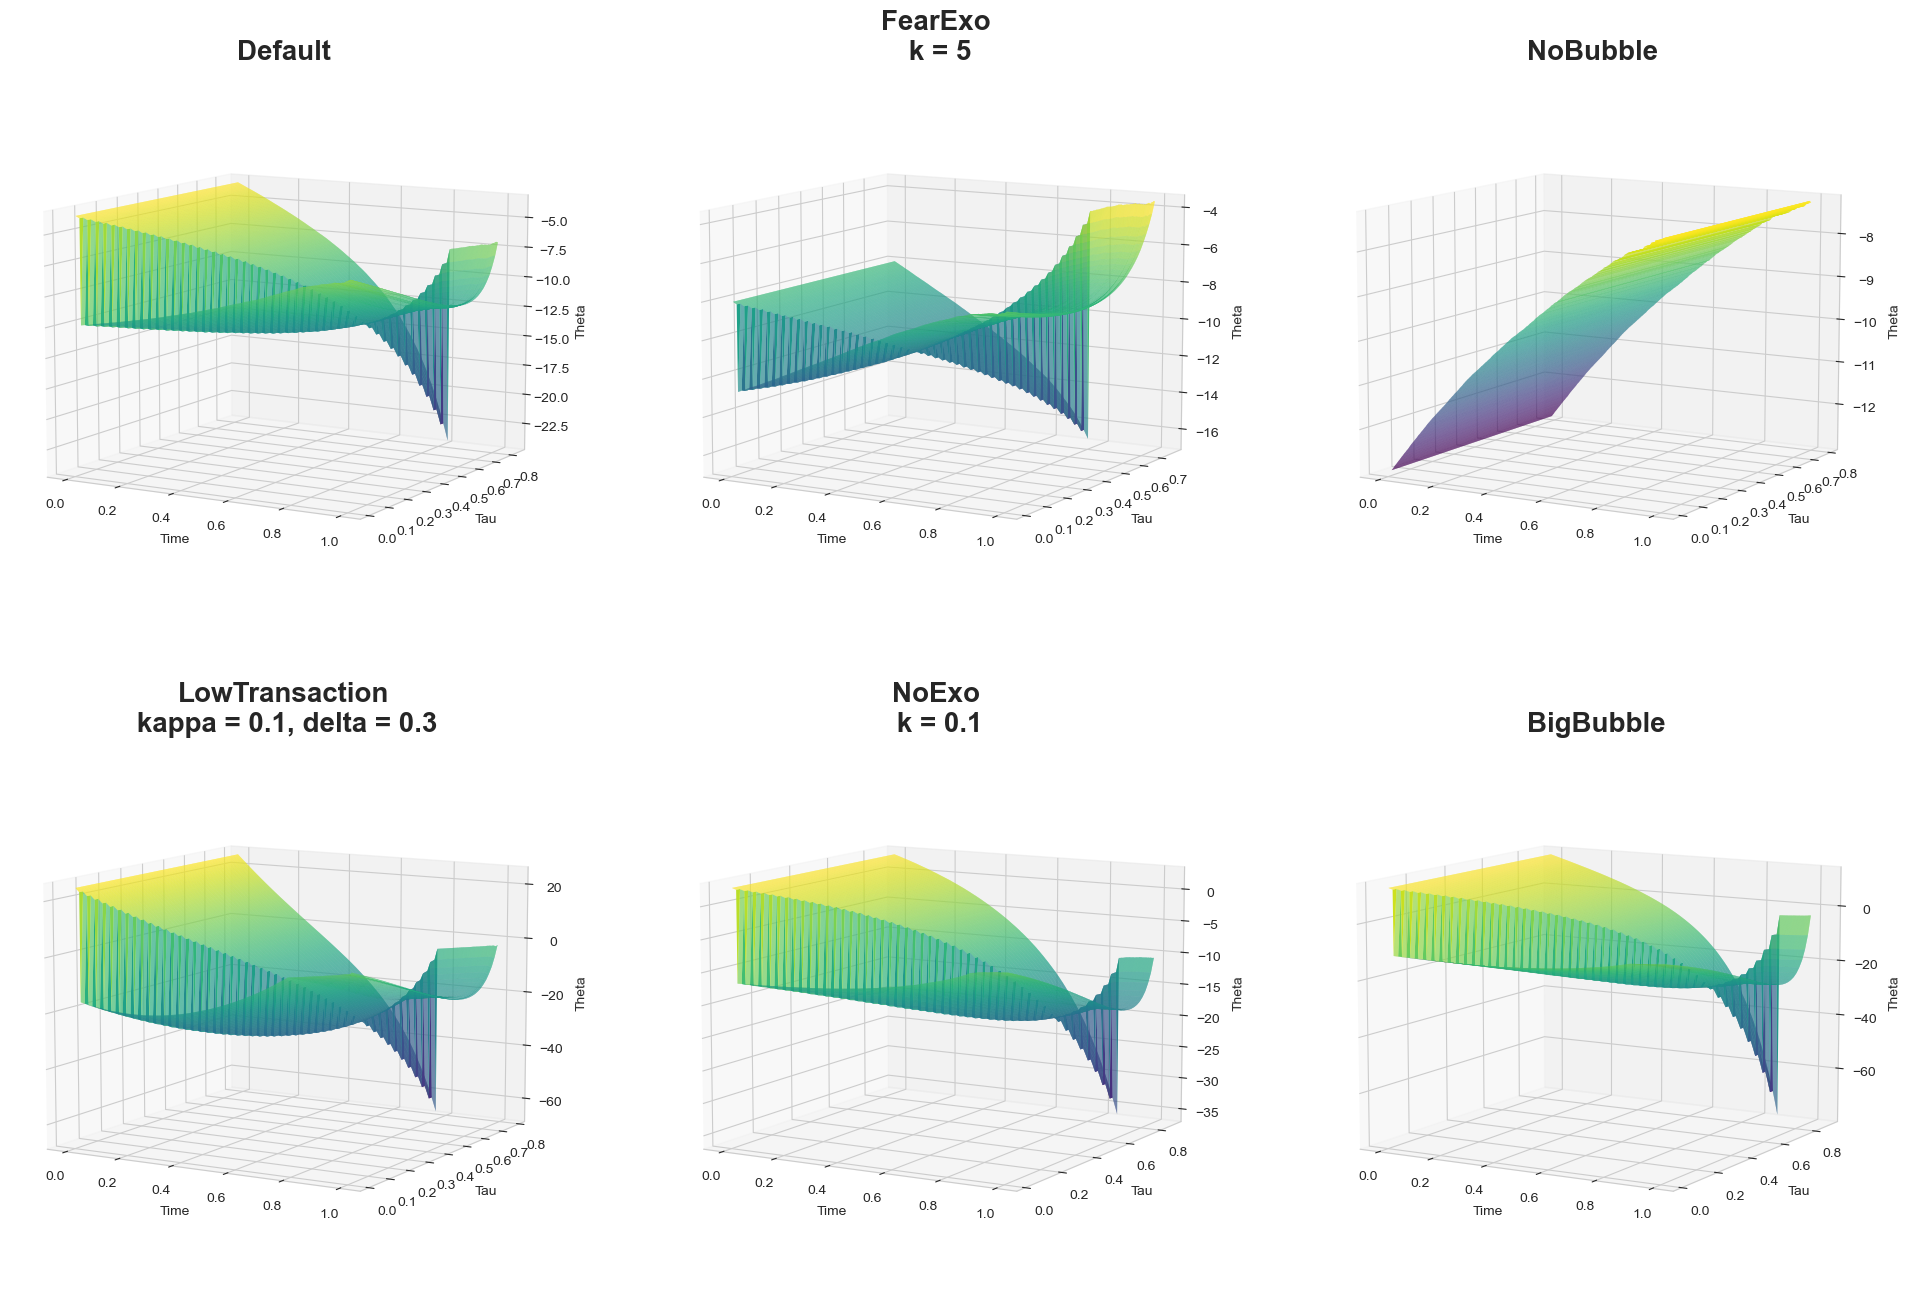

In [164]:
a, b = np.meshgrid(default.tgrid, default.testtaus)
fig = plt.figure(figsize = (24, 16))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.plot_surface(a, b, default.thetas_ntau, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.view_init(azim = -60, elev = 10)
ax.set_xlabel('Time')
ax.set_ylabel('Tau')
ax.set_zlabel('Theta')
ax.set_title("Default", fontsize =  20, fontweight = "bold")
ax = fig.add_subplot(2, 3, 4, projection='3d')
a, b = np.meshgrid(LowTransaction.tgrid, LowTransaction.testtaus)
ax.plot_surface(a, b, LowTransaction.thetas_ntau, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(azim = -60, elev = 10)
ax.set_xlabel('Time')
ax.set_ylabel('Tau')
ax.set_zlabel('Theta')
ax.set_title("LowTransaction\n kappa = 0.1, delta = 0.3", fontsize =  20, fontweight = "bold")

ax = fig.add_subplot(2, 3, 2, projection='3d')
a, b = np.meshgrid(FearExo.tgrid, FearExo.testtaus)
ax.plot_surface(a, b, FearExo.thetas_ntau, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(azim = -60, elev = 10)
ax.set_xlabel('Time')
ax.set_ylabel('Tau')
ax.set_zlabel('Theta')
ax.set_title("FearExo \n k = 5 ", fontsize =  20, fontweight = "bold")

ax = fig.add_subplot(2, 3, 5, projection='3d')
a, b = np.meshgrid(NoExo.tgrid, NoExo.testtaus)
ax.plot_surface(a, b, NoExo.thetas_ntau, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(azim = -60, elev = 10)
ax.set_xlabel('Time')
ax.set_ylabel('Tau')
ax.set_zlabel('Theta')
ax.set_title("NoExo \n k = 0.1 ", fontsize =  20, fontweight = "bold")

ax = fig.add_subplot(2, 3, 3, projection='3d')
a, b = np.meshgrid(NoBubble.tgrid, NoBubble.testtaus)
ax.plot_surface(a, b, NoBubble.thetas_ntau, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(azim = -60, elev = 10)
ax.set_xlabel('Time')
ax.set_ylabel('Tau')
ax.set_zlabel('Theta')
ax.set_title("NoBubble ", fontsize =  20, fontweight = "bold")


ax = fig.add_subplot(2, 3, 6, projection='3d')
a, b = np.meshgrid(BigBubble.tgrid, BigBubble.testtaus)
ax.plot_surface(a, b, BigBubble.thetas_ntau, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(azim = -60, elev = 10)
ax.set_xlabel('Time')
ax.set_ylabel('Tau')
ax.set_zlabel('Theta')
ax.set_title("BigBubble", fontsize =  20, fontweight = "bold")
plt.show()

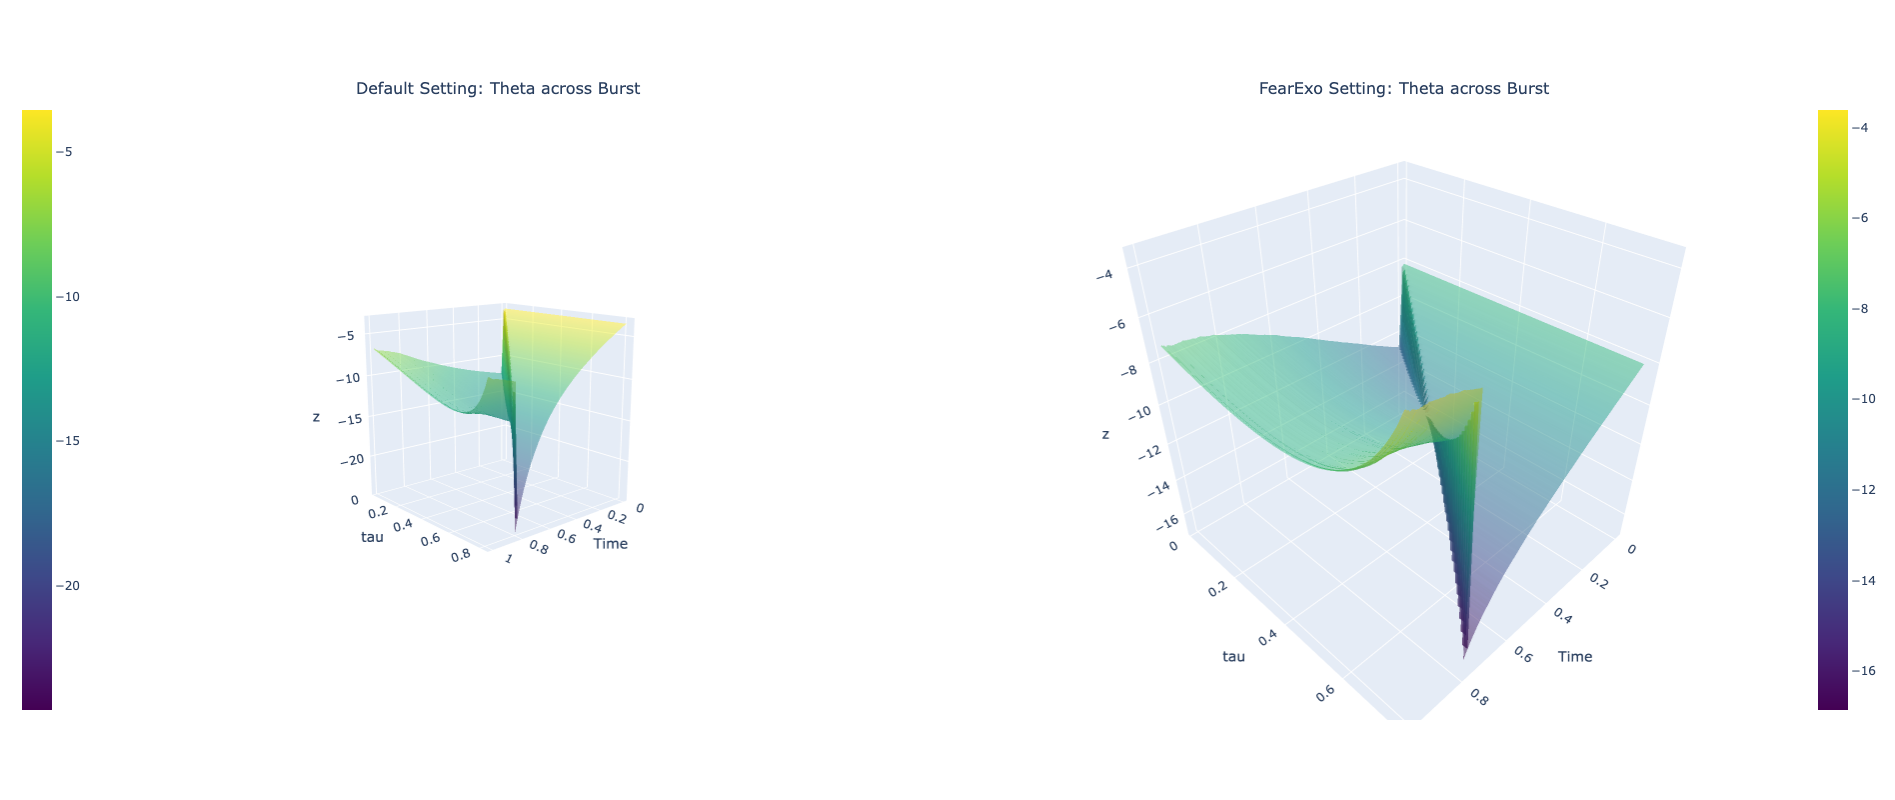

In [151]:
fig = make_subplots(rows = 1, cols = 2,   specs=[[{'is_3d': True}, {'is_3d': True}]],
                    subplot_titles=['Default Setting: Theta across Burst', 'FearExo Setting: Theta across Burst']
                    )
fig.add_trace(go.Surface(z= default.thetas_ntau, x = default.tgrid, y = default.testtaus, colorbar_x=-0.07, colorscale='viridis', opacity=0.5), 1, 1)
fig.add_trace(go.Surface(z= FearExo.thetas_ntau, x = FearExo.tgrid, y = FearExo.testtaus,colorscale='viridis', opacity=0.5), 1, 2)

fig.update_layout(scene = dict(xaxis_title = "Time", yaxis_title = "tau"), scene2 = dict(xaxis_title = "Time", yaxis_title = "tau"),
    autosize=False,
    width=1600,
    height=800)
fig.show()

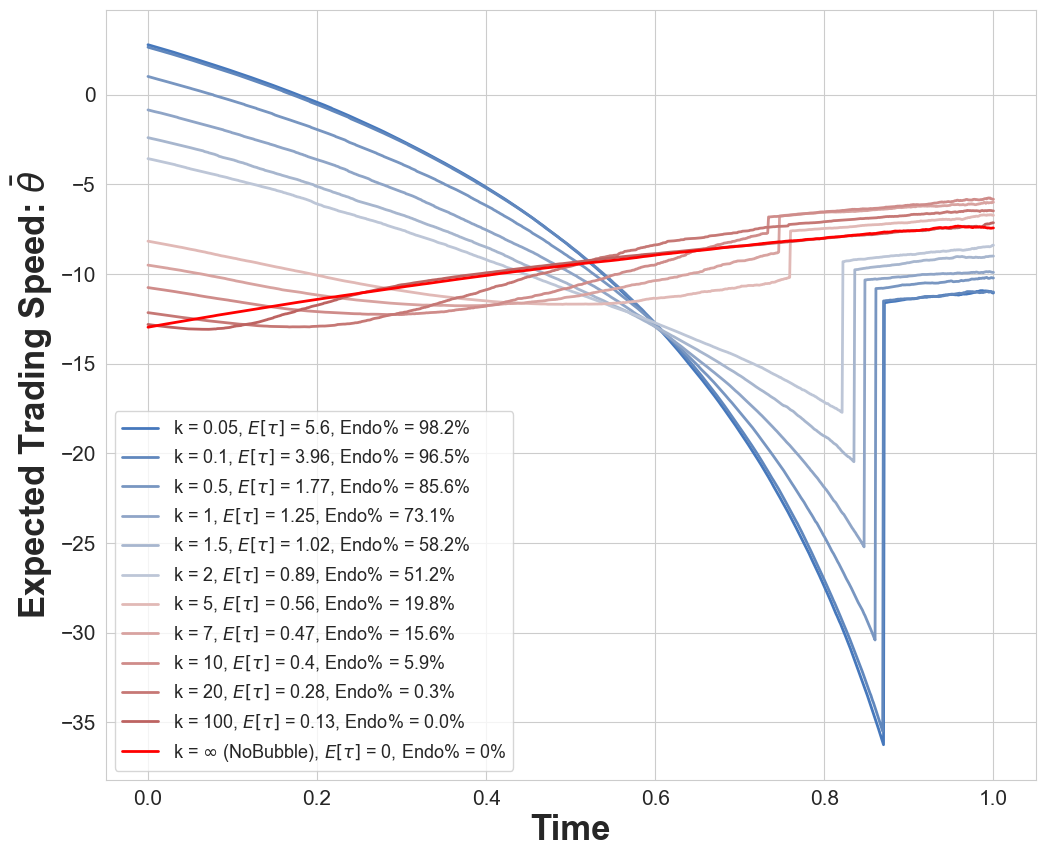

In [153]:
sns.set_style("whitegrid")
ks = default_k_analysis.ks
K = len(ks)
fig, ax = plt.subplots(figsize=(12, 10))
palette = sns.color_palette("vlag",K + 6)
for i in range(K):
    if i <= 5:
        ax.plot(default_k_analysis.tgrid, default_k_analysis.theta_ks[i], lw=2, color = palette[i],
            label=r"k = {k}, $E[\tau]$ = {exp}, Endo% = {percent}%".format(k=ks[i], exp = np.round(np.sqrt(np.pi/(2*ks[i])), 2),  percent = np.round(100*default_k_analysis.endoPercent_ks[i],2)))
    else:
        ax.plot(default_k_analysis.tgrid, default_k_analysis.theta_ks[i], lw=2, color = palette[i+5],
            label=r"k = {k}, $E[\tau]$ = {exp}, Endo% = {percent}%".format(k=ks[i], exp = np.round(np.sqrt(np.pi/(2*ks[i])), 2),  percent = np.round(100*default_k_analysis.endoPercent_ks[i],2)))
ax.plot(NoBubble.tgrid, NoBubble.theta, lw=2, color = "red",
            label=r"k = $\infty$ (NoBubble), $E[\tau]$ = 0, Endo% = 0%")
ax.legend(loc="best", fontsize = 13)
ax.set_xlabel("Time", fontweight ="bold",fontsize = 25)
ax.set_ylabel(r"Expected Trading Speed: $\bar\theta$",fontweight ="bold", fontsize = 25)
ax.tick_params(labelsize=15)
plt.savefig('DifferentK_theta.png',bbox_inches='tight')


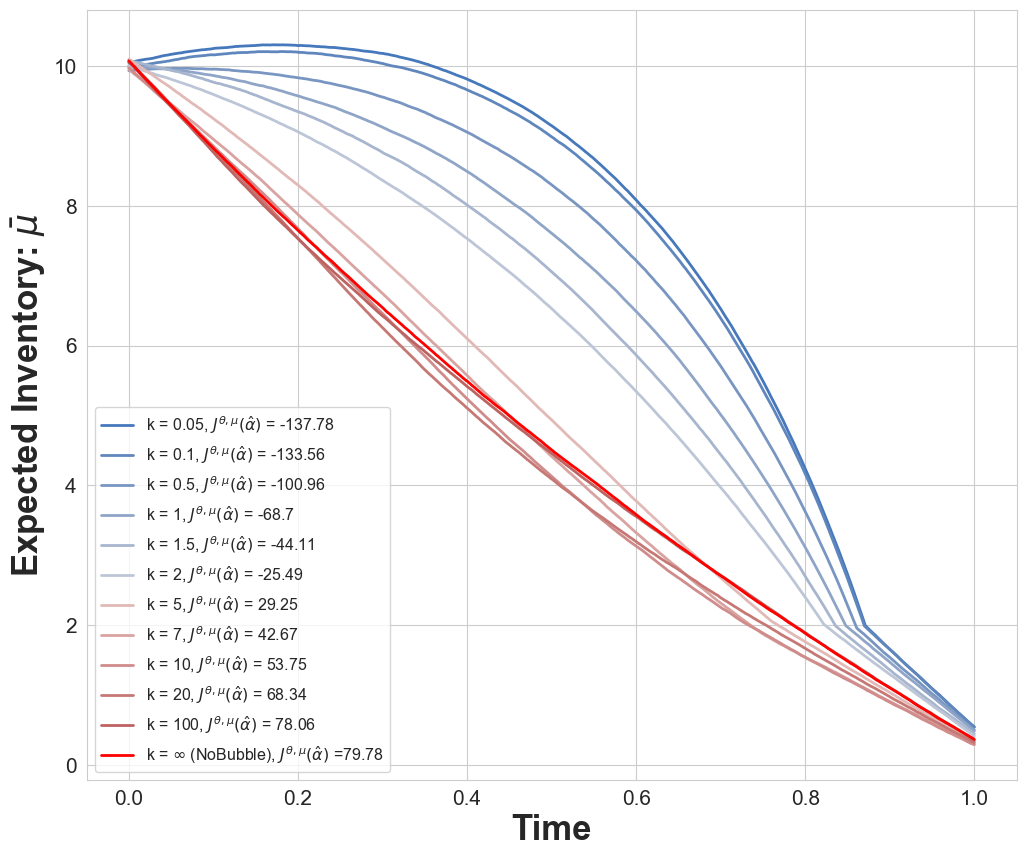

In [154]:
fig, ax = plt.subplots(figsize=(12, 10))
for i in range(K):
    if i <= 5:
        ax.plot(default_k_analysis.tgrid, default_k_analysis.mu_ks[i], lw=2,  color = palette[i],
            label="k = {k}".format(k = ks[i])+r", $J^{\theta,\mu}(\hat{\alpha})$"+" = {cost}".format(cost = np.round(default_k_analysis.obj_ks[i], 2),))
    else:
        ax.plot(default_k_analysis.tgrid, default_k_analysis.mu_ks[i], lw=2, color = palette[i+5],
            label="k = {k}".format(k = ks[i])+r", $J^{\theta,\mu}(\hat{\alpha})$"+" = {cost}".format(cost = np.round(default_k_analysis.obj_ks[i], 2),))
ax.plot(NoBubble.tgrid, NoBubble.mu, lw=2, color = "red",
            label=r"k = $\infty$ (NoBubble), $J^{\theta,\mu}(\hat{\alpha})$ =" + str(np.round(NoBubble.obj, 2)))
ax.legend(loc="best", fontsize = 11.5)
ax.set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax.set_ylabel(r"Expected Inventory: $\bar\mu$",fontweight ="bold", fontsize = 25)
ax.tick_params(labelsize=15)
#plt.show()
plt.savefig('DifferentK_mu.png',bbox_inches='tight')

**We choose temporary impact $\kappa = 0.5$, permanent impact $\delta = 1$, running cost $\phi = 0.1$, and terminal cost $c = 10$. Recall we also choose $\sigma = 1$.**

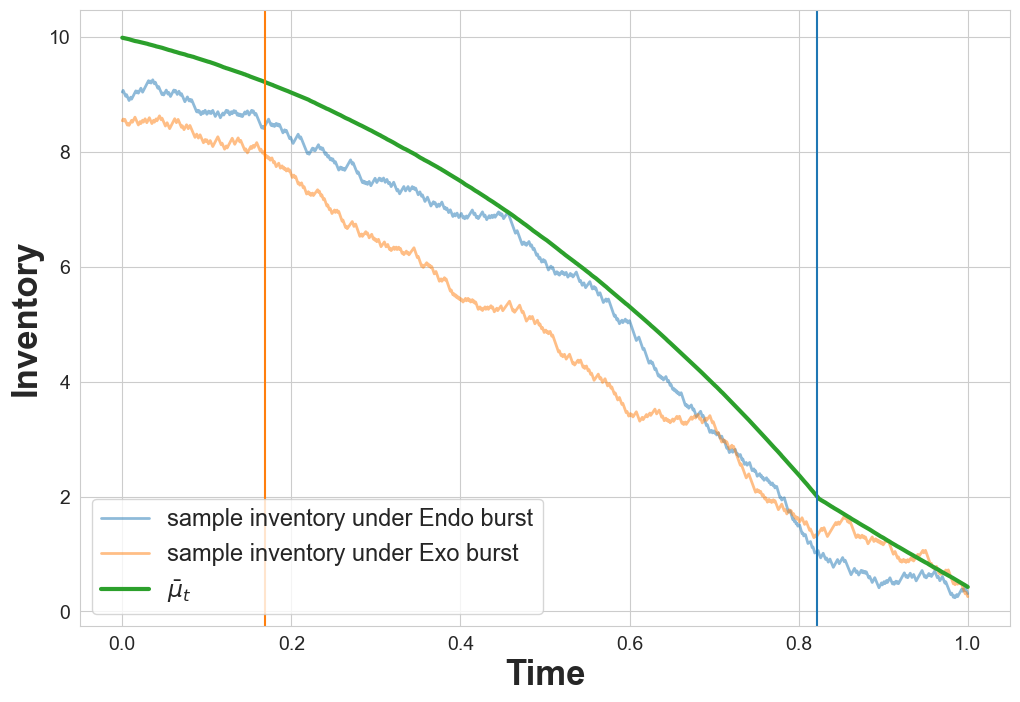

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(default.tgrid, default.Xtildes[default.n_endo], lw=2, alpha = 0.5, label="sample inventory under Endo burst")
ax.plot(default.tgrid, default.Xtildes[default.n_exo], lw=2, alpha = 0.5, label="sample inventory under Exo burst")
ax.plot(default.tgrid, default.mu, lw=3, label=r"$\bar\mu_t$")
ax.axvline(default.taus[default.n_exo], ymin = 0, ymax = 1, color = "C1")
ax.axvline(default.taubar, ymin = 0, ymax = 1, color = "C0")
ax.legend(loc="lower left", fontsize = 17)
ax.set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax.tick_params(labelsize=14)
ax.set_ylabel("Inventory",fontweight ="bold", fontsize = 25)
plt.show()

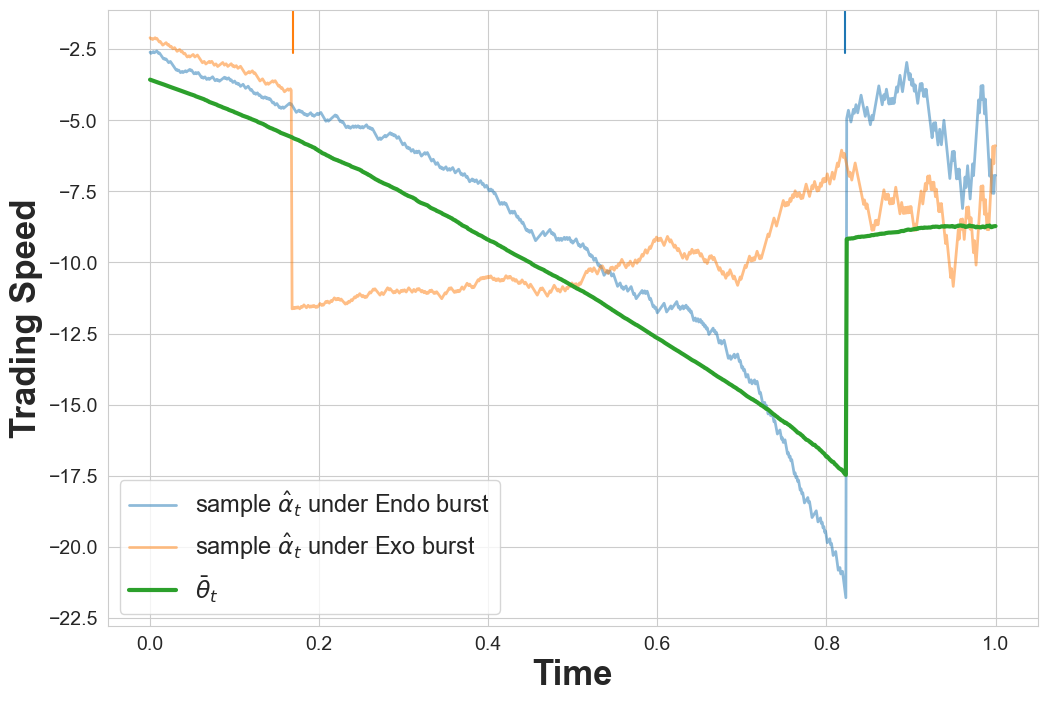

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(default.tgrid, default.alphas[default.n_endo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Endo burst")
ax.plot(default.tgrid, default.alphas[default.n_exo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Exo burst")
ax.plot(default.tgrid, default.theta, lw=3, label=r"$\bar\theta_t$")
ax.axvline(default.taus[default.n_exo], ymin = 0.93, ymax = 1, color = "C1")
ax.axvline(default.taubar, ymin = 0.93, ymax = 1, color = "C0")
ax.legend(loc="lower left", fontsize = 17)
ax.tick_params(labelsize=14)
ax.set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax.set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()

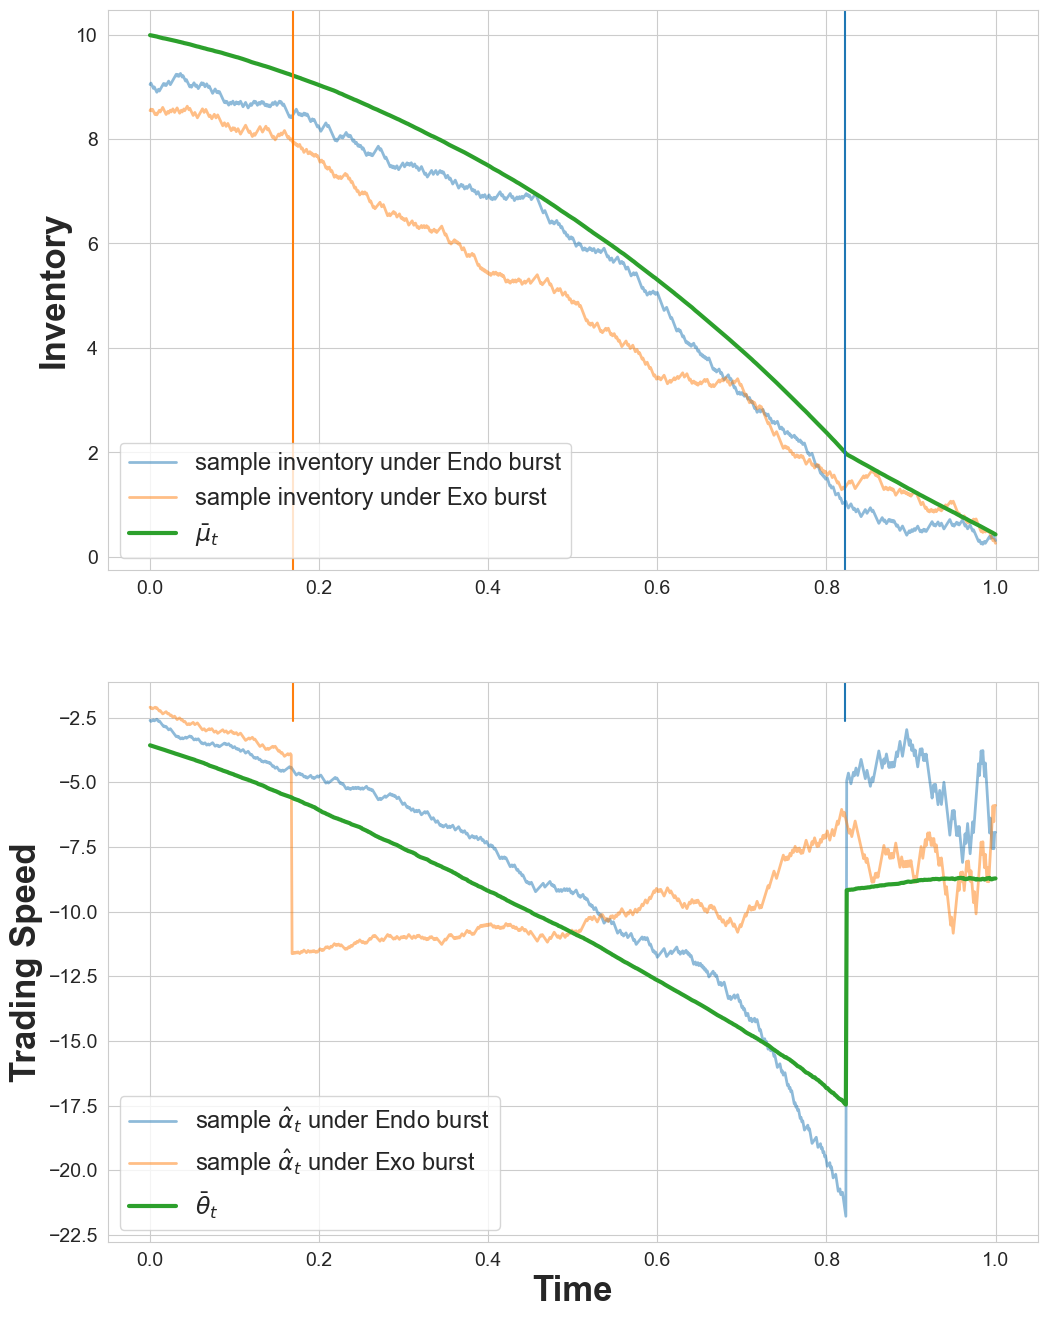

In [157]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(default.tgrid, default.Xtildes[default.n_endo], lw=2, alpha = 0.5, label="sample inventory under Endo burst")
ax[0].plot(default.tgrid, default.Xtildes[default.n_exo], lw=2, alpha = 0.5, label="sample inventory under Exo burst")
ax[0].plot(default.tgrid, default.mu, lw=3, label=r"$\bar\mu_t$")
ax[0].axvline(default.taus[default.n_exo], ymin = 0, ymax = 1, color = "C1")
ax[0].axvline(default.taubar, ymin = 0, ymax = 1, color = "C0")
ax[0].legend(loc="lower left", fontsize = 17)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel("Inventory",fontweight ="bold", fontsize = 25)

ax[1].plot(default.tgrid, default.alphas[default.n_endo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Endo burst")
ax[1].plot(default.tgrid, default.alphas[default.n_exo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Exo burst")
ax[1].plot(default.tgrid, default.theta, lw=3, label=r"$\bar\theta_t$")
ax[1].axvline(default.taus[default.n_exo], ymin = 0.93, ymax = 1, color = "C1")
ax[1].axvline(default.taubar, ymin = 0.93, ymax = 1, color = "C0")
ax[1].legend(loc="lower left", fontsize = 17)
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax[1].set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()

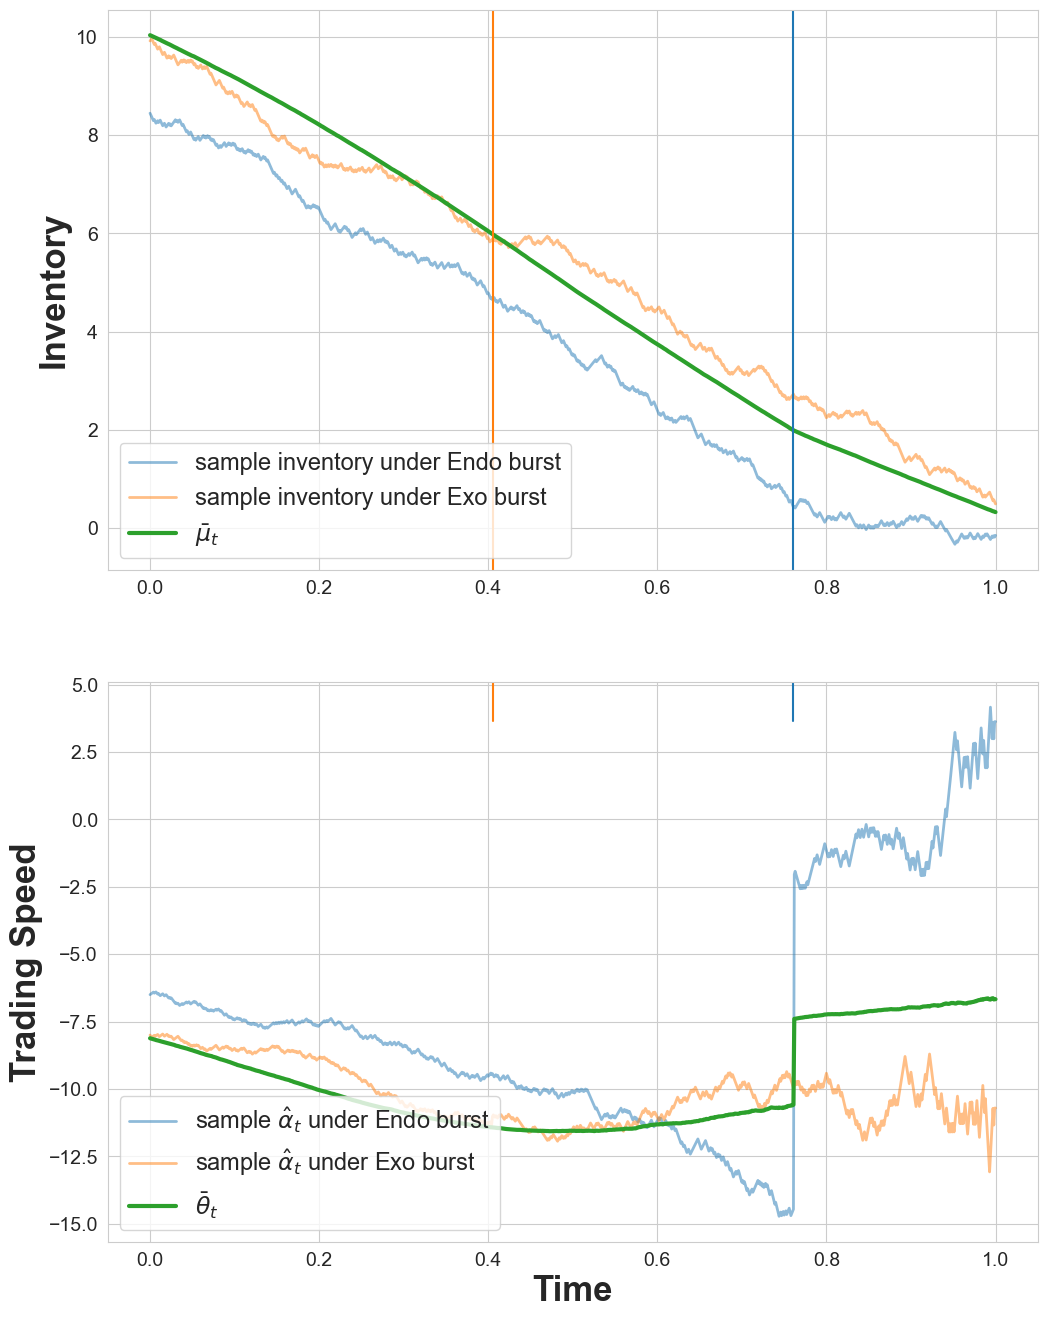

In [158]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(FearExo.tgrid, FearExo.Xtildes[FearExo.n_endo], lw=2, alpha = 0.5, label="sample inventory under Endo burst")
ax[0].plot(FearExo.tgrid, FearExo.Xtildes[FearExo.n_exo], lw=2, alpha = 0.5, label="sample inventory under Exo burst")
ax[0].plot(FearExo.tgrid, FearExo.mu, lw=3, label=r"$\bar\mu_t$")
ax[0].axvline(FearExo.taus[FearExo.n_exo], ymin = 0, ymax = 1, color = "C1")
ax[0].axvline(FearExo.taubar, ymin = 0, ymax = 1, color = "C0")
ax[0].legend(loc="lower left", fontsize = 17)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel("Inventory",fontweight ="bold", fontsize = 25)

ax[1].plot(FearExo.tgrid, FearExo.alphas[FearExo.n_endo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Endo burst")
ax[1].plot(FearExo.tgrid, FearExo.alphas[FearExo.n_exo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Exo burst")
ax[1].plot(FearExo.tgrid, FearExo.theta, lw=3, label=r"$\bar\theta_t$")
ax[1].axvline(FearExo.taus[FearExo.n_exo], ymin = 0.93, ymax = 1, color = "C1")
ax[1].axvline(FearExo.taubar, ymin = 0.93, ymax = 1, color = "C0")
ax[1].legend(loc="lower left", fontsize = 17)
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax[1].set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()

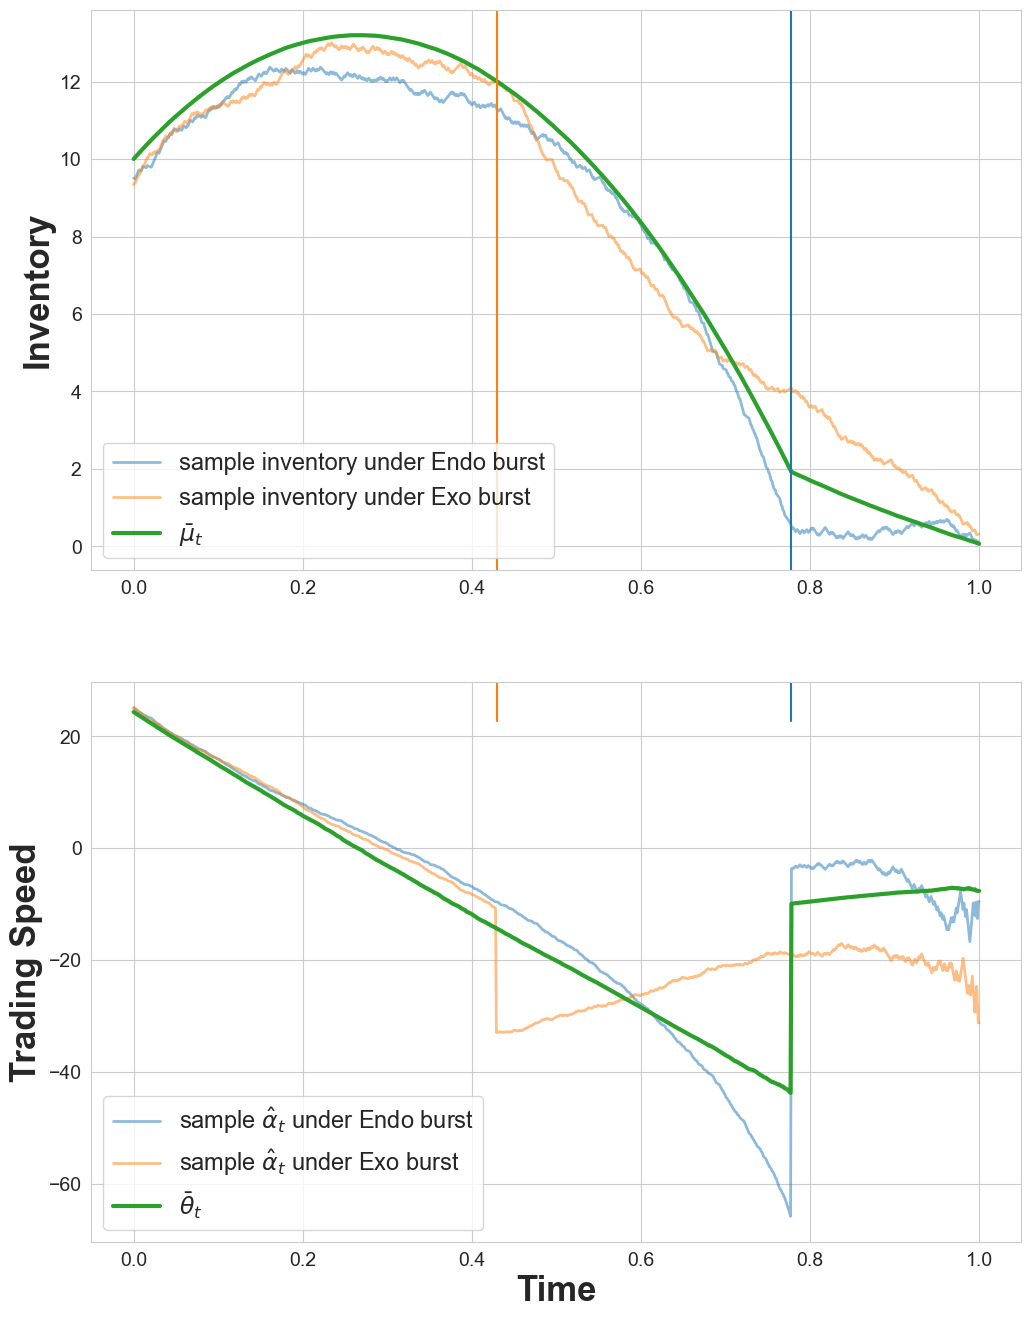

In [159]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(LowTransaction.tgrid, LowTransaction.Xtildes[LowTransaction.n_endo], lw=2, alpha = 0.5, label="sample inventory under Endo burst")
ax[0].plot(LowTransaction.tgrid, LowTransaction.Xtildes[LowTransaction.n_exo], lw=2, alpha = 0.5, label="sample inventory under Exo burst")
ax[0].plot(LowTransaction.tgrid, LowTransaction.mu, lw=3, label=r"$\bar\mu_t$")
ax[0].axvline(LowTransaction.taus[LowTransaction.n_exo], ymin = 0, ymax = 1, color = "C1")
ax[0].axvline(LowTransaction.taubar, ymin = 0, ymax = 1, color = "C0")
ax[0].legend(loc="lower left", fontsize = 17)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel("Inventory",fontweight ="bold", fontsize = 25)

ax[1].plot(LowTransaction.tgrid, LowTransaction.alphas[LowTransaction.n_endo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Endo burst")
ax[1].plot(LowTransaction.tgrid, LowTransaction.alphas[LowTransaction.n_exo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Exo burst")
ax[1].plot(LowTransaction.tgrid, LowTransaction.theta, lw=3, label=r"$\bar\theta_t$")
ax[1].axvline(LowTransaction.taus[LowTransaction.n_exo], ymin = 0.93, ymax = 1, color = "C1")
ax[1].axvline(LowTransaction.taubar, ymin = 0.93, ymax = 1, color = "C0")
ax[1].legend(loc="lower left", fontsize = 17)
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax[1].set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()

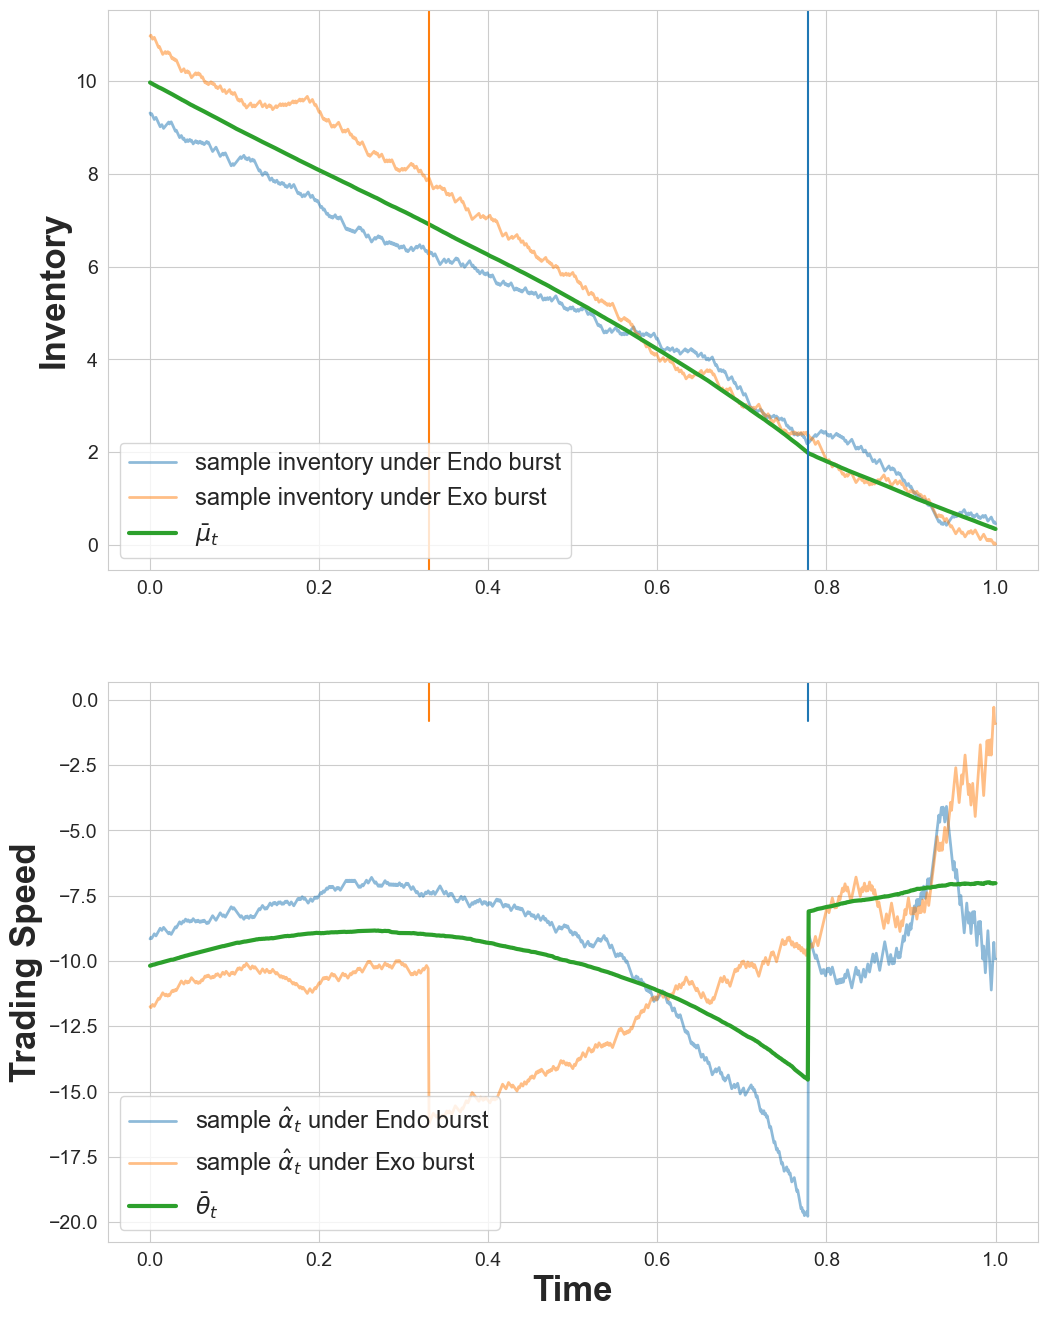

In [160]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(HighBurden.tgrid, HighBurden.Xtildes[HighBurden.n_endo], lw=2, alpha = 0.5, label="sample inventory under Endo burst")
ax[0].plot(HighBurden.tgrid, HighBurden.Xtildes[HighBurden.n_exo], lw=2, alpha = 0.5, label="sample inventory under Exo burst")
ax[0].plot(HighBurden.tgrid, HighBurden.mu, lw=3, label=r"$\bar\mu_t$")
ax[0].axvline(HighBurden.taus[HighBurden.n_exo], ymin = 0, ymax = 1, color = "C1")
ax[0].axvline(HighBurden.taubar, ymin = 0, ymax = 1, color = "C0")
ax[0].legend(loc="lower left", fontsize = 17)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel("Inventory",fontweight ="bold", fontsize = 25)

ax[1].plot(HighBurden.tgrid, HighBurden.alphas[HighBurden.n_endo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Endo burst")
ax[1].plot(HighBurden.tgrid, HighBurden.alphas[HighBurden.n_exo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Exo burst")
ax[1].plot(HighBurden.tgrid, HighBurden.theta, lw=3, label=r"$\bar\theta_t$")
ax[1].axvline(HighBurden.taus[HighBurden.n_exo], ymin = 0.93, ymax = 1, color = "C1")
ax[1].axvline(HighBurden.taubar, ymin = 0.93, ymax = 1, color = "C0")
ax[1].legend(loc="lower left", fontsize = 17)
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax[1].set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()

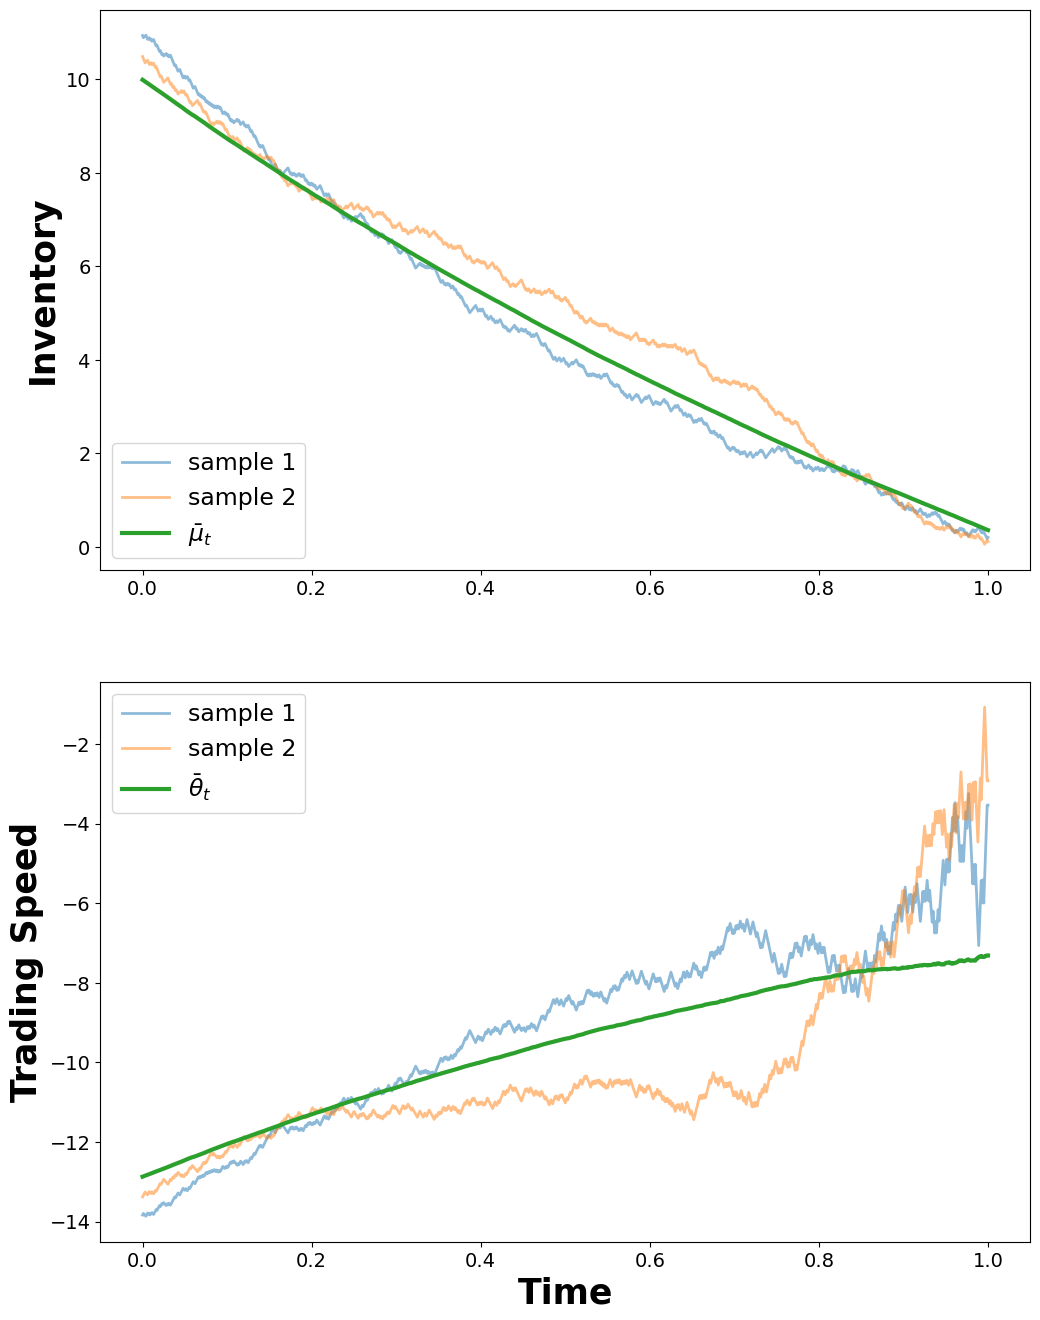

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(NoBubble.tgrid, NoBubble.Xtildes[NoBubble.n_endo], lw=2, alpha = 0.5, label="sample 1")
ax[0].plot(NoBubble.tgrid, NoBubble.Xtildes[NoBubble.n_exo], lw=2, alpha = 0.5, label="sample 2")
ax[0].plot(NoBubble.tgrid, NoBubble.mu, lw=3, label=r"$\bar\mu_t$")
ax[0].legend(loc="lower left", fontsize = 17)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel("Inventory",fontweight ="bold", fontsize = 25)

ax[1].plot(NoBubble.tgrid, NoBubble.alphas[NoBubble.n_endo], alpha = 0.5, lw=2, label=r"sample 1")
ax[1].plot(NoBubble.tgrid, NoBubble.alphas[NoBubble.n_exo], alpha = 0.5, lw=2, label=r"sample 2")
ax[1].plot(NoBubble.tgrid, NoBubble.theta, lw=3, label=r"$\bar\theta_t$")
ax[1].legend(loc="upper left", fontsize = 17)
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax[1].set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()

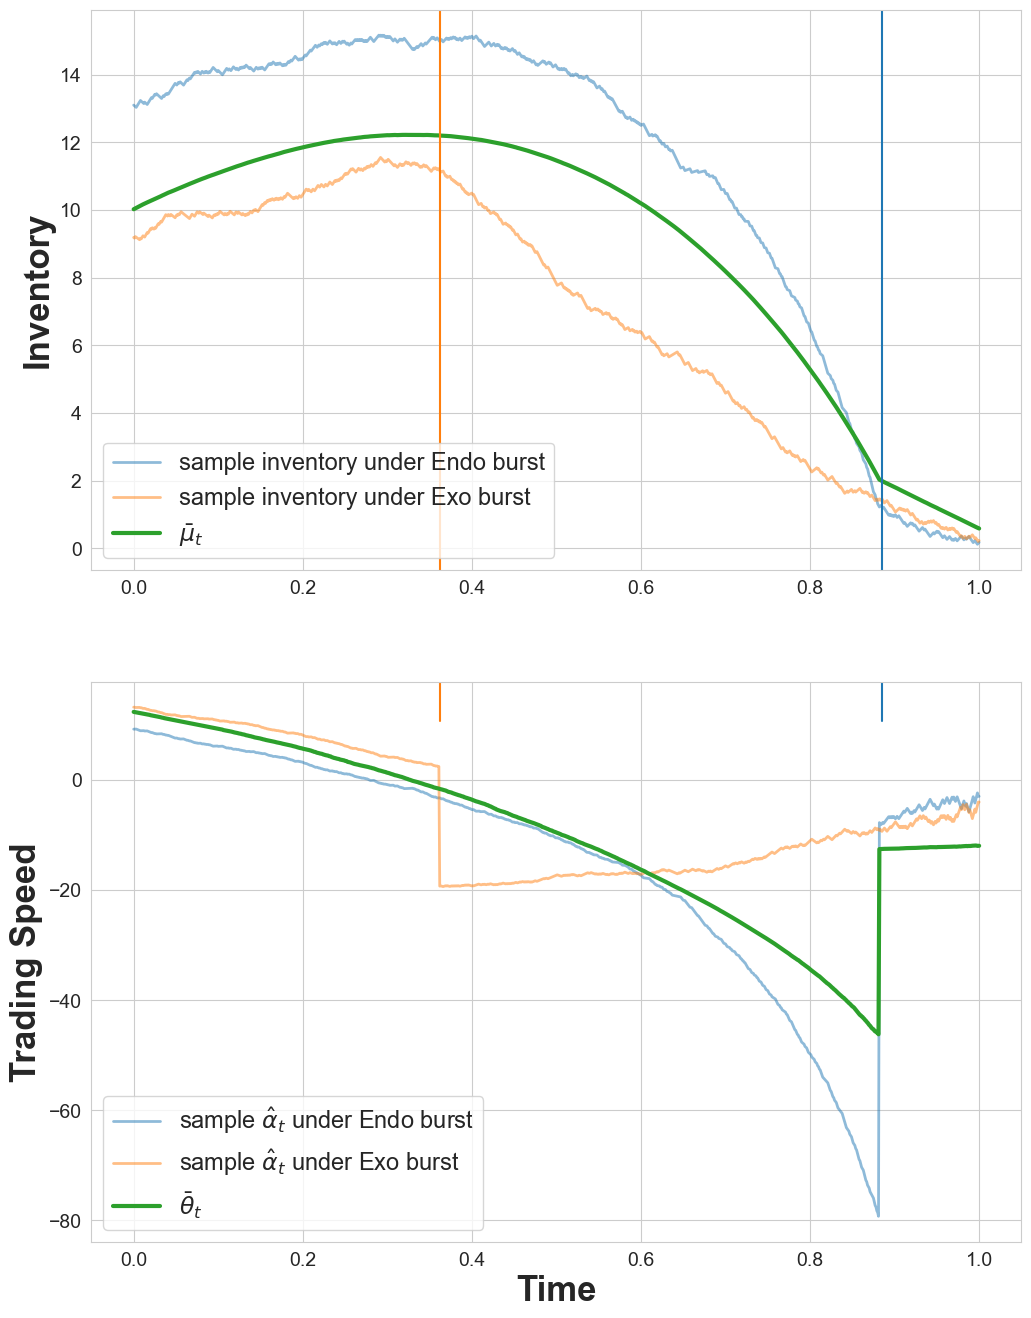

In [162]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(BigBubble.tgrid, BigBubble.Xtildes[BigBubble.n_endo], lw=2, alpha = 0.5, label="sample inventory under Endo burst")
ax[0].plot(BigBubble.tgrid, BigBubble.Xtildes[BigBubble.n_exo], lw=2, alpha = 0.5, label="sample inventory under Exo burst")
ax[0].plot(BigBubble.tgrid, BigBubble.mu, lw=3, label=r"$\bar\mu_t$")
ax[0].axvline(BigBubble.taus[BigBubble.n_exo], ymin = 0, ymax = 1, color = "C1")
ax[0].axvline(BigBubble.taubar, ymin = 0, ymax = 1, color = "C0")
ax[0].legend(loc="lower left", fontsize = 17)
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel("Inventory",fontweight ="bold", fontsize = 25)

ax[1].plot(BigBubble.tgrid, BigBubble.alphas[BigBubble.n_endo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Endo burst")
ax[1].plot(BigBubble.tgrid, BigBubble.alphas[BigBubble.n_exo], alpha = 0.5, lw=2, label=r"sample $\hat\alpha_t$ under Exo burst")
ax[1].plot(BigBubble.tgrid, BigBubble.theta, lw=3, label=r"$\bar\theta_t$")
ax[1].axvline(BigBubble.taus[BigBubble.n_exo], ymin = 0.93, ymax = 1, color = "C1")
ax[1].axvline(BigBubble.taubar, ymin = 0.93, ymax = 1, color = "C0")
ax[1].legend(loc="lower left", fontsize = 17)
ax[1].tick_params(labelsize=14)
ax[1].set_xlabel("Time",fontweight ="bold", fontsize = 25)
ax[1].set_ylabel("Trading Speed",fontweight ="bold", fontsize = 25)
plt.show()